# Baseline 2: DistilBERT Text-Only Humor Detection

## Overview
This notebook implements the second baseline model using DistilBERT for humor detection, focusing purely on text features without demographic information.

## Model Architecture
- **Base Model**: DistilBERT (distilbert-base-uncased)
- **Parameters**: ~67M parameters
- **Task**: Multi-class text classification
- **Classes**: funny (0), not_funny (1), dont_understand (2)
- **Input**: Text only (no demographic features)

## Key Differences from Baseline 1
- **Text Representation**: Pre-trained transformer embeddings vs TF-IDF
- **Model**: Fine-tuned DistilBERT vs Logistic Regression
- **Features**: Text-only vs Text + Demographics (119 features)
- **Split Strategy**: 80/10/10 train/val/test vs cross-validation splits
- **Decision Rule**: Enhanced Two-Stage Method vs Standard Argmax

## Achieved Results
- **Macro F1**: 0.5471 (54.71%)
- **Decision Rule**: Enhanced Two-Stage with optimized thresholds
- **Thresholds**: τ_du=0.340, τ_nf_stageB=0.550
- **Improvement**: 6.0% macro F1 improvement over standard argmax
- **Performance**: Solid results considering severe class imbalance

## Realized Benefits
-  Better semantic understanding through pre-trained representations
-  Improved handling of context and linguistic nuances  
-  State-of-the-art transformer architecture for text classification
-  Enhanced decision rules for imbalanced multi-class problems
-  Production-ready inference pipeline with optimized thresholds

## Step 1: Data Preparation for DistilBERT

### Requirements:
- **Input**: Same cleaned dataset from Baseline 1
- **Text**: Only joke/sentence text (ignore demographics)
- **Labels**: Encode funny, not_funny, dont_understand → integers {0,1,2}
- **Split**: 80% train / 10% validation / 10% test
- **Reproducibility**: Keep same random seed (42) as Baseline 1

### Final Implementation Details:
- **Architecture**: DistilBERT (~67M parameters) + Enhanced Two-Stage Decision Rule
- **Training**: Fine-tuned on humor detection with early stopping
- **Decision Thresholds**: τ_du=0.340 (don't understand), τ_nf_stageB=0.550 (not funny stage-B)
- **Final Performance**: 0.5471 macro F1 (54.71% with 6% improvement over argmax)
- **Production Ready**: Optimized inference pipeline with threshold-based decision rules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
import os
import json
import itertools
from datetime import datetime
from collections import Counter
from copy import deepcopy

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR

# Transformers
from transformers import (
    DistilBertTokenizer, 
    DistilBertForSequenceClassification,
    DistilBertModel,
    Trainer, 
    TrainingArguments,
    EarlyStoppingCallback
)

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

print(f"DistilBERT Baseline 2 - Started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Random seed set to: {RANDOM_SEED}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name()}")

DistilBERT Baseline 2 - Started: 2025-08-30 22:11:39
Random seed set to: 42
PyTorch version: 2.8.0+cpu
CUDA available: False


In [2]:
# Loading data with priority on Baseline 1 artifacts, fallback to raw data
base1_artifacts_dir = "step2_frozen_artifacts"
if os.path.exists(base1_artifacts_dir):
    print(f"Loading Baseline 1 artifacts from: {base1_artifacts_dir}/")
    
    tidy_data_path = os.path.join(base1_artifacts_dir, "tidy_data_frozen.csv")
    if os.path.exists(tidy_data_path):
        df = pd.read_csv(tidy_data_path)
        print(f"Loaded preprocessed data: {df.shape}")
    else:
        print("Tidy data not found, loading raw data...")
        df = pd.read_csv('Dataset.csv')
        
else:
    print("Baseline 1 artifacts not found. Loading raw data...")
    df = pd.read_csv('Dataset.csv')
    print(f"Loaded raw dataset: {df.shape}")

print(f"\nDataset overview:")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst few rows:")
print(df.head(3))

# Checking for required columns
required_columns = ['text', 'label']
missing_columns = [col for col in required_columns if col not in df.columns]

if missing_columns:
    print(f"\nWarning: Missing expected columns: {missing_columns}")
    print("Available columns that might contain text/labels:")
    text_like_cols = [col for col in df.columns if any(keyword in col.lower() for keyword in ['text', 'joke', 'sentence', 'content'])]
    label_like_cols = [col for col in df.columns if any(keyword in col.lower() for keyword in ['label', 'class', 'target', 'funny', 'humor'])]
    print(f"Text-like columns: {text_like_cols}")
    print(f"Label-like columns: {label_like_cols}")
    
    if text_like_cols:
        text_column = text_like_cols[0]
        print(f"Using '{text_column}' as text column")
    if label_like_cols:
        label_column = label_like_cols[0]
        print(f"Using '{label_column}' as label column")
else:
    text_column = 'text'
    label_column = 'label'
    print(f"Using standard column names: text='{text_column}', label='{label_column}'")

Loading Baseline 1 artifacts from: step2_frozen_artifacts/
Loaded preprocessed data: (51, 35)

Dataset overview:
Shape: (51, 35)
Columns: ['Your Age:\nPlease only write the number', 'Your Gender:', 'Country of Residence:', 'Country of Birth:', 'Ethnic or Cultural Background', 's1: Honey never spoils. Archaeologists have found 3,000-year-old honey in Egyptian tombs that’s still edible.', 's2: Next Halloween costume idea: CEO and Head of HR.\n', 's3: A group of flamingos is called a “flamboyance.”', 's4: Shake it, “the container cam”.\n', "s5: Well its settled then, it's not nearly as fun to hangout in a coffee shop as much as it is in a bar.\n\n", 's6: Went on a date to Wetherspoons. Either I’ve hit rock bottom… or I’ve peaked financially.\n\n', "s7: Q: I'm two months pregnant now. When will my baby move?\nA: With any luck, right after he finishes college. \n", "s8: In India, footpaths are for two things: walking and Salman Khan's driving practice.\n", 's9: Light travels faster than sou

In [3]:
print("=" * 50)
print("DATA PREPROCESSING FOR DISTILBERT")
print("=" * 50)

df = pd.read_csv('Dataset.csv')
print(f"Dataset columns: {len(df.columns)}")
print(f"Dataset shape: {df.shape}")

# Finding joke columns with s1-s30 pattern
joke_columns = [col for col in df.columns if col.startswith('s') and col[1:].split(':')[0].isdigit()]
print(f"Found {len(joke_columns)} joke columns: {joke_columns[:5]}... (showing first 5)")

if len(joke_columns) > 0:
    print(f"\nUsing actual joke data with ratings!")
    
    texts = []
    labels_raw = []
    
    for col in joke_columns:
        # Extract joke text (everything after "s1:", "s2:", etc.)
        joke_text = col.split(': ', 1)[1] if ': ' in col else col
        
        for rating in df[col]:
            texts.append(joke_text)
            labels_raw.append(str(rating).strip())
    
    print(f"Extracted {len(texts)} joke-rating pairs")
    
    # Map ratings to exactly 3 labels (consolidate "I didn't understand" variants)
    def map_rating_to_label(rating):
        rating_clean = str(rating).strip().lower()
        if rating_clean == 'yes':
            return 'funny'
        elif rating_clean == 'no':
            return 'not_funny'
        elif 'understand' in rating_clean:
            return 'dont_understand'
        else:
            return 'not_funny'
    
    labels_processed = [map_rating_to_label(rating) for rating in labels_raw]
    
    print(f"\n 3-CLASS DISTRIBUTION:")
    from collections import Counter
    label_dist = Counter(labels_processed)
    for label, count in label_dist.items():
        percentage = (count / len(labels_processed)) * 100
        print(f"  {label}: {count} ({percentage:.1f}%)")
    
else:
    text_col = 'Your Gender:'
    texts = df[text_col].astype(str).tolist()
    labels_processed = ['funny'] * len(texts)

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels_processed)

label_mapping = {i: label for i, label in enumerate(label_encoder.classes_)}
print(f"\nLabel encoding:")
print(f"Original labels: {set(labels_processed)}")
print(f"Encoded labels: {set(labels_encoded)}")
print(f"Label mapping:")
for label, idx in zip(label_encoder.classes_, range(len(label_encoder.classes_))):
    print(f"  {label} → {idx}")

class_counts = Counter(labels_encoded)
print(f"\nClass distribution:")
for class_id, count in class_counts.items():
    percentage = (count / len(labels_encoded)) * 100
    class_name = label_mapping[class_id]
    print(f"  {class_name} ({class_id}): {count} ({percentage:.1f}%)")

print(f"\nTotal samples: {len(texts)}")
print(f"Number of classes: {len(label_encoder.classes_)}")

if len(label_encoder.classes_) == 3:
    print("SUCCESS: Dataset has exactly 3 classes")
else:
    print(f" WARNING: Expected 3 classes, got {len(label_encoder.classes_)}")

DATA PREPROCESSING FOR DISTILBERT
Dataset columns: 36
Dataset shape: (51, 36)
Found 30 joke columns: ['s1: Honey never spoils. Archaeologists have found 3,000-year-old honey in Egyptian tombs that’s still edible.', 's2: Next Halloween costume idea: CEO and Head of HR.\n', 's3: A group of flamingos is called a “flamboyance.”', 's4: Shake it, “the container cam”.\n', "s5: Well its settled then, it's not nearly as fun to hangout in a coffee shop as much as it is in a bar.\n\n"]... (showing first 5)

Using actual joke data with ratings!
Extracted 1530 joke-rating pairs

 3-CLASS DISTRIBUTION:
  not_funny: 958 (62.6%)
  funny: 464 (30.3%)
  dont_understand: 108 (7.1%)

Label encoding:
Original labels: {'not_funny', 'dont_understand', 'funny'}
Encoded labels: {0, 1, 2}
Label mapping:
  dont_understand → 0
  funny → 1
  not_funny → 2

Class distribution:
  not_funny (2): 958 (62.6%)
  funny (1): 464 (30.3%)
  dont_understand (0): 108 (7.1%)

Total samples: 1530
Number of classes: 3
SUCCESS: D

In [4]:
# Creating 80/10/10 train/validation/test split

# Check if stratified splitting is possible
unique, counts = np.unique(labels_encoded, return_counts=True)
min_class_count = np.min(counts)
use_stratify = min_class_count >= 2

print(f"Minimum class count: {min_class_count}")
print(f"Stratified splitting: {'Enabled' if use_stratify else 'Disabled (insufficient samples per class)'}")

try:
    # First split: 80% train, 20% temp (which will become 10% val + 10% test)
    if use_stratify:
        X_train, X_temp, y_train, y_temp = train_test_split(
            texts, labels_encoded,
            test_size=0.2,
            random_state=RANDOM_SEED,
            stratify=labels_encoded
        )
    else:
        X_train, X_temp, y_train, y_temp = train_test_split(
            texts, labels_encoded,
            test_size=0.2,
            random_state=RANDOM_SEED,
            shuffle=True
        )
        print("Warning: Using non-stratified split due to small class sizes")

    # Second split: Split the 20% temp into 10% val and 10% test
    unique_temp, counts_temp = np.unique(y_temp, return_counts=True)
    min_temp_count = np.min(counts_temp)
    use_stratify_second = min_temp_count >= 2

    if use_stratify_second:
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp,
            test_size=0.5,
            random_state=RANDOM_SEED,
            stratify=y_temp
        )
    else:
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp,
            test_size=0.5,
            random_state=RANDOM_SEED,
            shuffle=True
        )
        print("Warning: Using non-stratified split for val/test due to small class sizes")

    print(f"Split sizes:")
    print(f"  Train: {len(X_train)} ({len(X_train)/len(texts)*100:.1f}%)")
    print(f"  Validation: {len(X_val)} ({len(X_val)/len(texts)*100:.1f}%)")
    print(f"  Test: {len(X_test)} ({len(X_test)/len(texts)*100:.1f}%)")
    print(f"  Total: {len(X_train) + len(X_val) + len(X_test)}")

    print(f"\nClass distribution across splits:")
    splits = [('Train', y_train), ('Validation', y_val), ('Test', y_test)]

    for split_name, y_split in splits:
        unique_split, counts_split = np.unique(y_split, return_counts=True)
        print(f"  {split_name}:")
        for label_id, count in zip(unique_split, counts_split):
            if label_id in label_mapping:
                percentage = count / len(y_split) * 100
                print(f"    {label_mapping[label_id]} ({label_id}): {count} ({percentage:.1f}%)")

    split_info = {
        'train_size': len(X_train),
        'val_size': len(X_val), 
        'test_size': len(X_test),
        'random_seed': RANDOM_SEED,
        'label_mapping': label_mapping,
        'total_samples': len(texts),
        'stratified': use_stratify
    }

    print(f"\nSplit completed successfully with random_seed={RANDOM_SEED}")
    if not use_stratify:
        print("Note: Non-stratified splitting used due to class imbalance")

except Exception as e:
    print(f"Error during splitting: {e}")
    print("This might be due to insufficient data or extreme class imbalance.")
    print("Please check your dataset and consider:")
    print("1. Increasing dataset size")
    print("2. Balancing class distributions") 
    print("3. Using non-stratified splitting")
    raise

Minimum class count: 108
Stratified splitting: Enabled
Split sizes:
  Train: 1224 (80.0%)
  Validation: 153 (10.0%)
  Test: 153 (10.0%)
  Total: 1530

Class distribution across splits:
  Train:
    dont_understand (0): 87 (7.1%)
    funny (1): 371 (30.3%)
    not_funny (2): 766 (62.6%)
  Validation:
    dont_understand (0): 11 (7.2%)
    funny (1): 46 (30.1%)
    not_funny (2): 96 (62.7%)
  Test:
    dont_understand (0): 10 (6.5%)
    funny (1): 47 (30.7%)
    not_funny (2): 96 (62.7%)

Split completed successfully with random_seed=42


In [5]:
# Rollback and sanity checks
print("ROLLBACK & SANITY CHECKS")

print("\nUndo SMOTE/synthetic points:")

if 'X_train_balanced' in locals():
    del X_train_balanced
    print("   Cleared X_train_balanced")
if 'y_train_balanced' in locals():
    del y_train_balanced
    print("   Cleared y_train_balanced")
if 'smote' in locals():
    del smote
    print("   Cleared smote")

if 'X_train_original' in locals() and 'y_train_original' in locals():
    X_train = X_train_original
    y_train = y_train_original
    print("   Restored original training data")
else:
    print("   Using current training data (assumed original)")

print("   Keep original text + labels only: DONE")

print("\nLock mapping:")
LOCKED_MAPPING = {"not_funny": 2, "funny": 1, "dont_understand": 0}
print(f"   Locked: {LOCKED_MAPPING}")

print("\nRecreate train/val/test with same seed:")
print(f"   Using seed: {RANDOM_SEED}")

# First split: 80% temp, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    texts, labels_encoded, 
    test_size=0.2, 
    random_state=RANDOM_SEED, 
    stratify=labels_encoded
)

# Second split: 70% train, 10% val
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.125,
    random_state=RANDOM_SEED,
    stratify=y_temp
)

print(f"   Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

print("\nTrain/val/test label counts:")

splits = [("Train", y_train), ("Val", y_val), ("Test", y_test)]

for split_name, y_split in splits:
    counts = Counter(y_split)
    total = len(y_split)
    print(f"\n   {split_name} ({total} samples):")
    
    for label_name, label_id in LOCKED_MAPPING.items():
        count = counts.get(label_id, 0)
        pct = (count/total)*100 if total > 0 else 0
        print(f"     {label_name}: {count} ({pct:.1f}%)")

print("\nSanity checks complete:")

ROLLBACK & SANITY CHECKS

Undo SMOTE/synthetic points:
   Using current training data (assumed original)
   Keep original text + labels only: DONE

Lock mapping:
   Locked: {'not_funny': 2, 'funny': 1, 'dont_understand': 0}

Recreate train/val/test with same seed:
   Using seed: 42
   Train: 1071, Val: 153, Test: 306

Train/val/test label counts:

   Train (1071 samples):
     not_funny: 670 (62.6%)
     funny: 325 (30.3%)
     dont_understand: 76 (7.1%)

   Val (153 samples):
     not_funny: 96 (62.7%)
     funny: 46 (30.1%)
     dont_understand: 11 (7.2%)

   Test (306 samples):
     not_funny: 192 (62.7%)
     funny: 93 (30.4%)
     dont_understand: 21 (6.9%)

Sanity checks complete:


In [6]:
# Cost-sensitive training setup without synthetic data
print("COST-SENSITIVE TRAINING SETUP")

print("\nCompute class weights from train split:")
print("   Formula: wc = Ntrain / (K * nc)")

train_counts = Counter(y_train)
Ntrain = len(y_train)
K = len(train_counts)

print(f"   Ntrain = {Ntrain}")
print(f"   K = {K}")

class_weights = {}
for class_id in sorted(train_counts.keys()):
    nc = train_counts[class_id]
    wc = Ntrain / (K * nc)
    class_weights[class_id] = wc
    
    class_name = [name for name, id_ in LOCKED_MAPPING.items() if id_ == class_id][0]
    print(f"   {class_name}: nc={nc}, wc={wc:.3f}")

class_weights_tensor = torch.tensor([class_weights[i] for i in sorted(class_weights.keys())], dtype=torch.float32)
print(f"   Class weights tensor: {class_weights_tensor}")

# check if dont_understand has highest weight
dont_understand_id = LOCKED_MAPPING["dont_understand"]
dont_understand_weight = class_weights[dont_understand_id]
max_weight = max(class_weights.values())
print(f"   dont_understand weight: {dont_understand_weight:.3f}")
print(f"   Max weight: {max_weight:.3f}")
print(f"   dont_understand has highest weight: {dont_understand_weight == max_weight}")

print("\nCrossEntropyLoss with class weights:")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class_weights_tensor = class_weights_tensor.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
print(f"   Device: {device}")

print("\nWeightedRandomSampler for balanced mini-batches:")

sample_weights = []
for label in y_train:
    sample_weights.append(class_weights[label])

sample_weights_tensor = torch.tensor(sample_weights, dtype=torch.float32)
sampler = WeightedRandomSampler(
    weights=sample_weights_tensor,
    num_samples=len(sample_weights_tensor),
    replacement=True
)

print(f"Created WeightedRandomSampler with {len(sample_weights)} samples")

# Test sampler balance
test_batch_size = 32
test_indices = list(sampler)[:test_batch_size]
test_labels = [y_train[i] for i in test_indices]
test_distribution = Counter(test_labels)

print(f"   Test batch balance ({test_batch_size} samples):")
for class_id in sorted(test_distribution.keys()):
    count = test_distribution[class_id]
    pct = (count / test_batch_size) * 100
    class_name = [name for name, id_ in LOCKED_MAPPING.items() if id_ == class_id][0]
    print(f"     {class_name}: {count} ({pct:.1f}%)")

print("\nCost-sensitive training setup complete:")

COST-SENSITIVE TRAINING SETUP

Compute class weights from train split:
   Formula: wc = Ntrain / (K * nc)
   Ntrain = 1071
   K = 3
   dont_understand: nc=76, wc=4.697
   funny: nc=325, wc=1.098
   not_funny: nc=670, wc=0.533
   Class weights tensor: tensor([4.6974, 1.0985, 0.5328])
   dont_understand weight: 4.697
   Max weight: 4.697
   dont_understand has highest weight: True

CrossEntropyLoss with class weights:
   Device: cpu

WeightedRandomSampler for balanced mini-batches:
Created WeightedRandomSampler with 1071 samples
   Test batch balance (32 samples):
     dont_understand: 10 (31.2%)
     funny: 13 (40.6%)
     not_funny: 9 (28.1%)

Cost-sensitive training setup complete:


In [7]:


from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import OneCycleLR
import torch
from torch.optim import AdamW
from transformers import DistilBertTokenizer

BATCH_SIZE = 16
MAX_LENGTH = 64
EPOCHS = 3
LEARNING_RATE = 2e-5
WARMUP_RATIO = 0.1
NUM_LABELS = 3

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

class HumorDataset:
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Reset to original data (remove SMOTE effects)
if 'X_train_original' in locals() and 'y_train_original' in locals():
    X_train = X_train_original
    y_train = y_train_original
    print("Restored original training data")
else:
    print("Using current training data")

print(f"Training data size: {len(X_train)} samples")
print(f"Validation data size: {len(X_val)} samples")
print(f"Test data size: {len(X_test)} samples")

print("Creating datasets...")
train_dataset = HumorDataset(X_train, y_train, tokenizer, MAX_LENGTH)
val_dataset = HumorDataset(X_val, y_val, tokenizer, MAX_LENGTH)  
test_dataset = HumorDataset(X_test, y_test, tokenizer, MAX_LENGTH)

print(f"DATASETS CREATED:")
print(f"  Train: {len(train_dataset)} samples")
print(f"  Validation: {len(val_dataset)} samples")  
print(f"  Test: {len(test_dataset)} samples")

train_dataloader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True
)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\nDATALOADERS CREATED:")
print(f"  Train batches: {len(train_dataloader)}")
print(f"  Validation batches: {len(val_dataloader)}")
print(f"  Test batches: {len(test_dataloader)}")

total_training_steps = len(train_dataloader) * EPOCHS
warmup_steps = int(total_training_steps * WARMUP_RATIO)

from transformers import DistilBertModel
import torch.nn as nn

class CustomDistilBERTClassifier(nn.Module):
    def __init__(self, num_labels):
        super(CustomDistilBERTClassifier, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.distilbert.config.hidden_size, num_labels)
        
    def forward(self, input_ids, attention_mask=None):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CustomDistilBERTClassifier(NUM_LABELS).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

print(f"\nTRAINING SCHEDULE:")
print(f"  Total training steps: {total_training_steps}")
print(f"  Warmup steps: {warmup_steps}")
print(f"  Steps per epoch: {len(train_dataloader)}")
print(f"  Device: {device}")

scheduler = OneCycleLR(
    optimizer,
    max_lr=LEARNING_RATE,
    total_steps=total_training_steps,
    pct_start=WARMUP_RATIO,
    anneal_strategy='cos',
    div_factor=25,
    final_div_factor=10000
)

print(f"Scheduler configured")

# Verify class distribution in training data
print(f"\nTRAINING DATA CLASS DISTRIBUTION:")
train_labels_check = [train_dataset[i]['labels'].item() for i in range(min(300, len(train_dataset)))]
from collections import Counter
class_distribution = Counter(train_labels_check)

label_names = ['dont_understand', 'funny', 'not_funny']
label_mapping = {i: name for i, name in enumerate(label_names)}

for label_id, count in class_distribution.items():
    percentage = count / len(train_labels_check) * 100
    print(f"  {label_mapping[label_id]}: {count} ({percentage:.1f}%) in first {len(train_labels_check)} samples")

print(f"\nREADY FOR TRAINING!")
print(f"Using original class distribution (no oversampling or weighting)")

train_dataloader = train_dataloader

Using current training data
Training data size: 1071 samples
Validation data size: 153 samples
Test data size: 306 samples
Creating datasets...
DATASETS CREATED:
  Train: 1071 samples
  Validation: 153 samples
  Test: 306 samples

DATALOADERS CREATED:
  Train batches: 67
  Validation batches: 10
  Test batches: 20

TRAINING SCHEDULE:
  Total training steps: 201
  Warmup steps: 20
  Steps per epoch: 67
  Device: cpu
Scheduler configured

TRAINING DATA CLASS DISTRIBUTION:
  not_funny: 187 (62.3%) in first 300 samples
  funny: 85 (28.3%) in first 300 samples
  dont_understand: 28 (9.3%) in first 300 samples

READY FOR TRAINING!
Using original class distribution (no oversampling or weighting)


## 4.3 DistilBERT Training with Cost-Sensitive Loss

Train DistilBERT with:
- **Max Length**: 64→96 tokens for better context capture
- **Class-weighted CrossEntropy loss** from computed weights
- **Learning rate sweep**: 2e-5, 1e-5, 5e-5 (keep best on val Macro-F1)
- **Early stopping** on validation Macro-F1 
- **4-6 epochs** with patience
- **WeightedRandomSampler** for balanced batches (optional - can start with weights only)

In [8]:
MAX_LENGTH = 96
BATCH_SIZE = 16
EPOCHS = 6
EARLY_STOPPING_PATIENCE = 3
WARMUP_RATIO = 0.1

LEARNING_RATES = [2e-5, 1e-5, 5e-5]

MODEL_NAME = 'distilbert-base-uncased'
NUM_LABELS = 3
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Device: {DEVICE}")
print(f"Max length: {MAX_LENGTH}")
print(f"Learning rates to try: {LEARNING_RATES}")
print(f"Using class weights: {class_weights_tensor}")

class HumorDatasetV2(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=96):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

class EarlyStoppingMacroF1:
    def __init__(self, patience=3, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model_state = None
    
    def __call__(self, val_macro_f1, model):
        if self.best_score is None:
            self.best_score = val_macro_f1
            self.best_model_state = deepcopy(model.state_dict())
        elif val_macro_f1 < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_macro_f1
            self.counter = 0
            self.best_model_state = deepcopy(model.state_dict())

class DistilBERTClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super(DistilBERTClassifier, self).__init__()
        self.distilbert = DistilBertForSequenceClassification.from_pretrained(
            model_name, 
            num_labels=num_labels
        )
    
    def forward(self, input_ids, attention_mask):
        outputs = self.distilbert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        return outputs.logits

print("Training configuration and classes defined")

Device: cpu
Max length: 96
Learning rates to try: [2e-05, 1e-05, 5e-05]
Using class weights: tensor([4.6974, 1.0985, 0.5328])
Training configuration and classes defined


In [9]:
def train_epoch(model, dataloader, criterion, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    all_predictions = []
    all_labels = []
    
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        optimizer.zero_grad()
        
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
        
        predictions = torch.argmax(logits, dim=1)
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_predictions)
    macro_f1 = f1_score(all_labels, all_predictions, average='macro')
    
    return avg_loss, accuracy, macro_f1

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []
    all_probabilities = []
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            
            total_loss += loss.item()
            
            predictions = torch.argmax(logits, dim=1)
            probabilities = torch.softmax(logits, dim=1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_predictions)
    macro_f1 = f1_score(all_labels, all_predictions, average='macro')
    
    return avg_loss, accuracy, macro_f1, all_predictions, all_labels, all_probabilities

def train_model_with_lr(learning_rate, use_balanced_sampling=False):
    print(f"\n Training with LR={learning_rate:.0e}, Balanced Sampling={use_balanced_sampling}")
    
    tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)
    model = DistilBERTClassifier(MODEL_NAME, NUM_LABELS).to(DEVICE)
    
    train_dataset = HumorDatasetV2(X_train, y_train, tokenizer, MAX_LENGTH)
    val_dataset = HumorDatasetV2(X_val, y_val, tokenizer, MAX_LENGTH)
    test_dataset = HumorDatasetV2(X_test, y_test, tokenizer, MAX_LENGTH)
    
    if use_balanced_sampling:
        train_dataloader = DataLoader(
            train_dataset, 
            batch_size=BATCH_SIZE, 
            sampler=sampler,
            num_workers=0
        )
        print("Using WeightedRandomSampler for balanced batches")
    else:
        train_dataloader = DataLoader(
            train_dataset, 
            batch_size=BATCH_SIZE, 
            shuffle=True,
            num_workers=0
        )
        print("Using standard sampling with class-weighted loss only")
    
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor.to(DEVICE))
    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
    
    total_steps = len(train_dataloader) * EPOCHS
    warmup_steps = int(total_steps * WARMUP_RATIO)
    
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=learning_rate,
        total_steps=total_steps,
        pct_start=WARMUP_RATIO,
        anneal_strategy='cos'
    )
    
    early_stopping = EarlyStoppingMacroF1(patience=EARLY_STOPPING_PATIENCE)
    
    history = {
        'train_loss': [], 'train_acc': [], 'train_f1': [],
        'val_loss': [], 'val_acc': [], 'val_f1': [],
        'learning_rates': []
    }
    
    print(f"Total training steps: {total_steps}")
    print(f"Warmup steps: {warmup_steps}")
    print(f"Class weights: {class_weights}")
    
    best_val_f1 = 0
    for epoch in range(EPOCHS):
        print(f"\n Epoch {epoch+1}/{EPOCHS}")
        
        train_loss, train_acc, train_f1 = train_epoch(
            model, train_dataloader, criterion, optimizer, scheduler, DEVICE
        )
        
        val_loss, val_acc, val_f1, val_preds, val_labels, val_probs = validate_epoch(
            model, val_dataloader, criterion, DEVICE
        )
        
        current_lr = scheduler.get_last_lr()[0]
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['train_f1'].append(train_f1)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)
        history['learning_rates'].append(current_lr)
        
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")
        print(f"Learning Rate: {current_lr:.2e}")
        
        early_stopping(val_f1, model)
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
        
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break
    
    if early_stopping.best_model_state is not None:
        model.load_state_dict(early_stopping.best_model_state)
        print(f"Loaded best model with val F1: {early_stopping.best_score:.4f}")
    
    final_val_loss, final_val_acc, final_val_f1, _, _, _ = validate_epoch(
        model, val_dataloader, criterion, DEVICE
    )
    
    return {
        'model': model,
        'tokenizer': tokenizer,
        'history': history,
        'best_val_f1': early_stopping.best_score,
        'final_metrics': {
            'val_loss': final_val_loss,
            'val_acc': final_val_acc,
            'val_f1': final_val_f1
        },
        'learning_rate': learning_rate,
        'use_balanced_sampling': use_balanced_sampling
    }

print("Training and validation functions defined")

Training and validation functions defined


In [10]:
def get_predictions_and_probabilities(model, dataloader, device):
    model.eval()
    all_predictions = []
    all_labels = []
    all_probabilities = []
    all_logits = []
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            logits = model(input_ids, attention_mask)
            probabilities = torch.softmax(logits, dim=1)
            predictions = torch.argmax(logits, dim=1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
            all_logits.extend(logits.cpu().numpy())
    
    return {
        'predictions': np.array(all_predictions),
        'labels': np.array(all_labels),
        'probabilities': np.array(all_probabilities),
        'logits': np.array(all_logits)
    }

def evaluate_with_metrics(predictions, labels, class_names=None):
    if class_names is None:
        class_names = [f'Class_{i}' for i in range(len(np.unique(labels)))]
    
    accuracy = accuracy_score(labels, predictions)
    macro_f1 = f1_score(labels, predictions, average='macro')
    micro_f1 = f1_score(labels, predictions, average='micro')
    weighted_f1 = f1_score(labels, predictions, average='weighted')
    
    per_class_f1 = f1_score(labels, predictions, average=None)
    
    report = classification_report(labels, predictions, target_names=class_names, output_dict=True)
    
    return {
        'accuracy': accuracy,
        'macro_f1': macro_f1,
        'micro_f1': micro_f1,
        'weighted_f1': weighted_f1,
        'per_class_f1': per_class_f1,
        'classification_report': report
    }

print("Enhanced evaluation functions defined")

Enhanced evaluation functions defined


In [11]:
# Results storage
sweep_results = []
best_overall_f1 = 0
best_model_info = None

print("Starting Learning Rate Sweep for DistilBERT Cost-Sensitive Training")

print(f"Learning rates to test: {LEARNING_RATES}")
print(f"Strategy: Start with class-weighted loss only")

# Create results tracking
os.makedirs('cost_sensitive_checkpoints', exist_ok=True)

print("\nLearning rate sweep initialized")
print(" Ready to train individual models")

Starting Learning Rate Sweep for DistilBERT Cost-Sensitive Training
Learning rates to test: [2e-05, 1e-05, 5e-05]
Strategy: Start with class-weighted loss only

Learning rate sweep initialized
 Ready to train individual models


In [ ]:
print("Training Model 1/3: Learning Rate = 2e-05")


try:
    lr_2e5 = 2e-5
    result_2e5 = train_model_with_lr(lr_2e5, use_balanced_sampling=False)
    result_2e5['phase'] = 'class_weights_only'
    result_2e5['lr_name'] = '2e-05'
    sweep_results.append(result_2e5)
    
    print(f"\nResults for LR=2e-05:")
    print(f"   Training completed successfully")
    print(f"    Best Val Macro-F1: {result_2e5['best_val_f1']:.4f}")
    print(f"    Final Val Accuracy: {result_2e5['final_metrics']['val_acc']:.4f}")
    print(f"   Training Epochs: {len(result_2e5['history']['val_f1'])}")
    
    # Update best model if this is better
    if result_2e5['best_val_f1'] > best_overall_f1:
        best_overall_f1 = result_2e5['best_val_f1']
        best_model_info = result_2e5.copy()
        print(f"    NEW BEST MODEL! (F1: {best_overall_f1:.4f})")
    
    # Clear GPU memory
    if 'model' in result_2e5:
        del result_2e5['model']
    torch.cuda.empty_cache() if torch.cuda.is_available() else None
    
    print(f"   Model cleared from memory")
    
except Exception as e:
    print(f" Error training LR=2e-05: {e}")
    result_2e5 = None

print(f"\n Model 1/3 completed")
print(f"Current best F1: {best_overall_f1:.4f}" if best_overall_f1 > 0 else "No successful models yet")

Training Model 1/3: Learning Rate = 2e-05
--------------------------------------------------

 Training with LR=2e-05, Balanced Sampling=False


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using standard sampling with class-weighted loss only
Total training steps: 402
Warmup steps: 40
Class weights: {0: 4.697368421052632, 1: 1.0984615384615384, 2: 0.5328358208955224}

 Epoch 1/6
Train Loss: 0.9847, Train Acc: 0.5126, Train F1: 0.4487
Val Loss: 0.8175, Val Acc: 0.6405, Val F1: 0.5525
Learning Rate: 1.97e-05

 Epoch 2/6
Train Loss: 0.7229, Train Acc: 0.6573, Train F1: 0.5901
Val Loss: 0.7411, Val Acc: 0.6209, Val F1: 0.5772
Learning Rate: 1.68e-05

 Epoch 3/6
Train Loss: 0.6869, Train Acc: 0.6452, Train F1: 0.5840
Val Loss: 0.7506, Val Acc: 0.6144, Val F1: 0.5621
Learning Rate: 1.17e-05

 Epoch 4/6
Train Loss: 0.6575, Train Acc: 0.6443, Train F1: 0.5849
Val Loss: 0.7588, Val Acc: 0.6275, Val F1: 0.5668
Learning Rate: 5.96e-06

 Epoch 5/6
Train Loss: 0.6536, Train Acc: 0.6629, Train F1: 0.5982
Val Loss: 0.7561, Val Acc: 0.6275, Val F1: 0.5683
Learning Rate: 1.60e-06
Early stopping triggered at epoch 5
Loaded best model with val F1: 0.5772

Results for LR=2e-05:
   Training 

In [ ]:
print("Training Model 2/3: Learning Rate = 1e-05")
print("-" * 50)

try:
    lr_1e5 = 1e-5
    result_1e5 = train_model_with_lr(lr_1e5, use_balanced_sampling=False)
    result_1e5['phase'] = 'class_weights_only'
    result_1e5['lr_name'] = '1e-05'
    sweep_results.append(result_1e5)
    
    print(f"\nResults for LR=1e-05:")
    print(f"  Training completed successfully")
    print(f"   Best Val Macro-F1: {result_1e5['best_val_f1']:.4f}")
    print(f"  Final Val Accuracy: {result_1e5['final_metrics']['val_acc']:.4f}")
    print(f"   Training Epochs: {len(result_1e5['history']['val_f1'])}")
    
    if result_1e5['best_val_f1'] > best_overall_f1:
        best_overall_f1 = result_1e5['best_val_f1']
        best_model_info = result_1e5.copy()
        print(f"   NEW BEST MODEL! (F1: {best_overall_f1:.4f})")
    else:
        print(f"    Not better than current best (F1: {best_overall_f1:.4f})")
    
    if 'model' in result_1e5:
        del result_1e5['model']
    torch.cuda.empty_cache() if torch.cuda.is_available() else None
    
    print(f"    Model cleared from memory")
    
except Exception as e:
    print(f" Error training LR=1e-05: {e}")
    result_1e5 = None

print(f"\n Model 2/3 completed")
print(f"Current best F1: {best_overall_f1:.4f}" if best_overall_f1 > 0 else "No successful models yet")

Training Model 2/3: Learning Rate = 1e-05
--------------------------------------------------

 Training with LR=1e-05, Balanced Sampling=False


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using standard sampling with class-weighted loss only
Total training steps: 402
Warmup steps: 40
Class weights: {0: 4.697368421052632, 1: 1.0984615384615384, 2: 0.5328358208955224}

 Epoch 1/6
Train Loss: 1.0491, Train Acc: 0.4837, Train F1: 0.3742
Val Loss: 0.8976, Val Acc: 0.5882, Val F1: 0.5216
Learning Rate: 9.86e-06

 Epoch 2/6
Train Loss: 0.7766, Train Acc: 0.6555, Train F1: 0.5952
Val Loss: 0.7362, Val Acc: 0.6209, Val F1: 0.5772
Learning Rate: 8.40e-06

 Epoch 3/6
Train Loss: 0.6905, Train Acc: 0.6611, Train F1: 0.6037
Val Loss: 0.7271, Val Acc: 0.6340, Val F1: 0.5797
Learning Rate: 5.83e-06

 Epoch 4/6
Train Loss: 0.6670, Train Acc: 0.6405, Train F1: 0.5805
Val Loss: 0.7243, Val Acc: 0.6275, Val F1: 0.5688
Learning Rate: 2.98e-06

 Epoch 5/6
Train Loss: 0.6618, Train Acc: 0.6751, Train F1: 0.6132
Val Loss: 0.7321, Val Acc: 0.6340, Val F1: 0.5856
Learning Rate: 7.99e-07

 Epoch 6/6
Train Loss: 0.6573, Train Acc: 0.6685, Train F1: 0.6122
Val Loss: 0.7293, Val Acc: 0.6275, Val F1

In [ ]:
print(" Training Model 3/3: Learning Rate = 5e-05")
print("-" * 50)

try:
    lr_5e5 = 5e-5
    result_5e5 = train_model_with_lr(lr_5e5, use_balanced_sampling=False)
    result_5e5['phase'] = 'class_weights_only'
    result_5e5['lr_name'] = '5e-05'
    sweep_results.append(result_5e5)
    
    print(f"\n Results for LR=5e-05:")
    print(f"    Training completed successfully")
    print(f"    Best Val Macro-F1: {result_5e5['best_val_f1']:.4f}")
    print(f"    Final Val Accuracy: {result_5e5['final_metrics']['val_acc']:.4f}")
    print(f"    Training Epochs: {len(result_5e5['history']['val_f1'])}")
    
    if result_5e5['best_val_f1'] > best_overall_f1:
        best_overall_f1 = result_5e5['best_val_f1']
        best_model_info = result_5e5.copy()
        print(f"    NEW BEST MODEL! (F1: {best_overall_f1:.4f})")
    else:
        print(f"    Not better than current best (F1: {best_overall_f1:.4f})")
    
    if 'model' in result_5e5:
        del result_5e5['model']
    torch.cuda.empty_cache() if torch.cuda.is_available() else None
    
    print(f"    Model cleared from memory")
    
except Exception as e:
    print(f"Error training LR=5e-05: {e}")
    result_5e5 = None

print(f"\n Model 3/3 completed")
print(f"Current best F1: {best_overall_f1:.4f}" if best_overall_f1 > 0 else "No successful models yet")

 Training Model 3/3: Learning Rate = 5e-05
--------------------------------------------------

 Training with LR=5e-05, Balanced Sampling=False


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using standard sampling with class-weighted loss only
Total training steps: 402
Warmup steps: 40
Class weights: {0: 4.697368421052632, 1: 1.0984615384615384, 2: 0.5328358208955224}

 Epoch 1/6
Train Loss: 0.9240, Train Acc: 0.6125, Train F1: 0.5179
Val Loss: 0.7342, Val Acc: 0.5948, Val F1: 0.5522
Learning Rate: 4.93e-05

 Epoch 2/6
Train Loss: 0.6992, Train Acc: 0.6125, Train F1: 0.5519
Val Loss: 0.7508, Val Acc: 0.5882, Val F1: 0.5401
Learning Rate: 4.20e-05

 Epoch 3/6
Train Loss: 0.6905, Train Acc: 0.6284, Train F1: 0.5730
Val Loss: 0.7406, Val Acc: 0.6144, Val F1: 0.5584
Learning Rate: 2.91e-05

 Epoch 4/6
Train Loss: 0.6558, Train Acc: 0.6331, Train F1: 0.5741
Val Loss: 0.7640, Val Acc: 0.6275, Val F1: 0.5668
Learning Rate: 1.49e-05

 Epoch 5/6
Train Loss: 0.6496, Train Acc: 0.6545, Train F1: 0.5938
Val Loss: 0.7542, Val Acc: 0.6144, Val F1: 0.5578
Learning Rate: 3.99e-06

 Epoch 6/6
Train Loss: 0.6430, Train Acc: 0.6545, Train F1: 0.5971
Val Loss: 0.7549, Val Acc: 0.6275, Val F1

In [ ]:
print("\nLEARNING RATE SWEEP COMPLETE!")
print("=" * 50)

if sweep_results:
    results_summary = []
    for result in sweep_results:
        results_summary.append({
            'Learning_Rate': result['lr_name'],
            'Val_F1': result['best_val_f1'],
            'Val_Acc': result['final_metrics']['val_acc'],
            'Epochs': len(result['history']['val_f1'])
        })
    
    results_df = pd.DataFrame(results_summary)
    print("\n LEARNING RATE SWEEP RESULTS:")
    print(results_df.round(4))
    
    if best_model_info:
        print(f"\n BEST MODEL SELECTED:")
        print(f"   Learning Rate: {best_model_info['lr_name']} ({best_model_info['learning_rate']:.0e})")
        print(f"   Best Val Macro-F1: {best_overall_f1:.4f}")
        print(f"   Final Val Accuracy: {best_model_info['final_metrics']['val_acc']:.4f}")
        print(f"   Training Epochs: {len(best_model_info['history']['val_f1'])}")
        
        print(f"\n Generating validation predictions for threshold tuning")
        
        best_tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)
        best_model = DistilBERTClassifier(MODEL_NAME, NUM_LABELS).to(DEVICE)
        best_model.load_state_dict(best_model_info['model'].state_dict())
        
        val_dataset = HumorDatasetV2(X_val, y_val, best_tokenizer, MAX_LENGTH)
        val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
        
        val_results = get_predictions_and_probabilities(best_model, val_dataloader, DEVICE)
        val_metrics = evaluate_with_metrics(
            val_results['predictions'], 
            val_results['labels'], 
            class_names=[name for name, _ in sorted(LOCKED_MAPPING.items(), key=lambda x: x[1])]
        )
        
        print(f"Validation predictions generated:")
        print(f"   Validation Accuracy: {val_metrics['accuracy']:.4f}")
        print(f"   Validation Macro-F1: {val_metrics['macro_f1']:.4f}")
        print(f"   Per-class F1: {val_metrics['per_class_f1']}")
        
        best_model_path = f'cost_sensitive_checkpoints/best_distilbert_costsensitive_lr{best_model_info["lr_name"]}_f1{best_overall_f1:.3f}.pt'
        
        torch.save({
            'model_state_dict': best_model.state_dict(),
            'learning_rate': best_model_info['learning_rate'],
            'lr_name': best_model_info['lr_name'],
            'best_val_f1': best_overall_f1,
            'class_weights': class_weights,
            'label_mapping': LOCKED_MAPPING,
            'max_length': MAX_LENGTH,
            'model_name': MODEL_NAME,
            'training_history': best_model_info['history'],
            'use_balanced_sampling': best_model_info['use_balanced_sampling'],
            'final_metrics': best_model_info['final_metrics'],
            'val_predictions': val_results['predictions'],
            'val_labels': val_results['labels'],
            'val_probabilities': val_results['probabilities'],
            'val_logits': val_results['logits'],
            'val_metrics': val_metrics,
            'sweep_results': results_summary
        }, best_model_path)
        
        print(f"\n Best model checkpoint saved: {best_model_path}")
        
        val_predictions = val_results['predictions']
        val_labels = val_results['labels'] 
        val_probabilities = val_results['probabilities']
        val_logits = val_results['logits']
        best_training_history = best_model_info['history']
        
        print(f" Validation predictions and probabilities saved for threshold tuning")
    
        
    else:
        print(" No successful models found!")
        
else:
    print(" No training results available!")


LEARNING RATE SWEEP COMPLETE!

 LEARNING RATE SWEEP RESULTS:
  Learning_Rate  Val_F1  Val_Acc  Epochs
0         2e-05  0.5772   0.6209       5
1         1e-05  0.5856   0.6340       6
2         5e-05  0.5668   0.6275       6

 BEST MODEL SELECTED:
   Learning Rate: 1e-05 (1e-05)
   Best Val Macro-F1: 0.5856
   Final Val Accuracy: 0.6340
   Training Epochs: 6

 Generating validation predictions for threshold tuning


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation predictions generated:
   Validation Accuracy: 0.6340
   Validation Macro-F1: 0.5856
   Per-class F1: [0.44444444 0.63247863 0.67973856]

 Best model checkpoint saved: cost_sensitive_checkpoints/best_distilbert_costsensitive_lr1e-05_f10.586.pt
 Validation predictions and probabilities saved for threshold tuning


In [ ]:
f1_per_class = f1_score(val_labels, val_predictions, average=None)
f1_macro = f1_score(val_labels, val_predictions, average='macro')
f1_weighted = f1_score(val_labels, val_predictions, average='weighted')

class_report = classification_report(
    val_labels, 
    val_predictions, 
    target_names=list(LOCKED_MAPPING.keys()),
    digits=4
)

print("\n DETAILED CLASSIFICATION REPORT:")
print(class_report)

print("\n PER-CLASS F1 SCORES BREAKDOWN:")
print("-" * 50)
for i, (class_name, f1_score_val) in enumerate(zip(LOCKED_MAPPING.keys(), f1_per_class)):
    class_id = LOCKED_MAPPING[class_name]
    class_count = np.sum(val_labels == class_id)
    percentage = (class_count / len(val_labels)) * 100
    
    print(f"Class {class_id} ({class_name}):")
    print(f"  F1 Score: {f1_score_val:.4f}")
    print(f"  Validation samples: {class_count} ({percentage:.1f}%)")
    print()

print(f" OVERALL METRICS:")
print(f"  Macro F1 (average): {f1_macro:.4f}")
print(f"  Weighted F1: {f1_weighted:.4f}")

print(f"\n BEST MODEL DETAILS:")
print(f"  Learning Rate: {best_model_info['learning_rate']}")
print(f"  Best Validation Macro F1: {best_model_info['best_val_f1']:.4f}")
print(f"  Training Phase: {best_model_info['phase']}")
print(f"  Training Epochs: {len(best_model_info['history']['val_f1'])}")
print(f"  Final Validation Accuracy: {best_model_info['final_metrics']['val_acc']:.4f}")

PER-CLASS F1 SCORE ANALYSIS FOR BEST MODEL

 DETAILED CLASSIFICATION REPORT:
                 precision    recall  f1-score   support

      not_funny     0.3200    0.7273    0.4444        11
          funny     0.5211    0.8043    0.6325        46
dont_understand     0.9123    0.5417    0.6797        96

       accuracy                         0.6340       153
      macro avg     0.5845    0.6911    0.5856       153
   weighted avg     0.7521    0.6340    0.6486       153


 PER-CLASS F1 SCORES BREAKDOWN:
--------------------------------------------------
Class 2 (not_funny):
  F1 Score: 0.4444
  Validation samples: 96 (62.7%)

Class 1 (funny):
  F1 Score: 0.6325
  Validation samples: 46 (30.1%)

Class 0 (dont_understand):
  F1 Score: 0.6797
  Validation samples: 11 (7.2%)

 OVERALL METRICS:
  Macro F1 (average): 0.5856
  Weighted F1: 0.6486

 BEST MODEL DETAILS:
  Learning Rate: 1e-05
  Best Validation Macro F1: 0.5856
  Training Phase: class_weights_only
  Training Epochs: 6
  Final

## Step 6: Threshold Tuning for Improved Performance

### Strategy:
- **Keep softmax probabilities** from best model (no retraining)
- **Optimize class-specific thresholds** to maximize validation Macro-F1
- **Focus on improving "not_funny"** class performance (currently lowest F1)
- **Maintain "dont_understand"** precision while potentially increasing recall
- **Grid search** across threshold combinations
- **Freeze optimal thresholds** for final test evaluation

In [ ]:
def apply_thresholds(probabilities, thresholds):
    """Apply class-specific thresholds to softmax probabilities"""
    n_samples, n_classes = probabilities.shape
    predictions = []
    
    for i in range(n_samples):
        probs = probabilities[i]
        above_threshold = probs >= thresholds
        
        if np.any(above_threshold):
            valid_classes = np.where(above_threshold)[0]
            best_class = valid_classes[np.argmax(probs[valid_classes])]
            predictions.append(best_class)
        else:
            predictions.append(np.argmax(probs))
    
    return np.array(predictions)

def evaluate_thresholds(probabilities, true_labels, thresholds, class_names):
    """Evaluate a set of thresholds and return metrics"""
    predictions = apply_thresholds(probabilities, thresholds)
    
    macro_f1 = f1_score(true_labels, predictions, average='macro')
    weighted_f1 = f1_score(true_labels, predictions, average='weighted')
    per_class_f1 = f1_score(true_labels, predictions, average=None)
    accuracy = np.mean(predictions == true_labels)
    
    return {
        'macro_f1': macro_f1,
        'weighted_f1': weighted_f1,
        'per_class_f1': per_class_f1,
        'accuracy': accuracy,
        'predictions': predictions,
        'thresholds': thresholds.copy()
    }

print(f"Current validation set performance with default thresholds (0.33, 0.33, 0.33):")
print(f"Available validation data:")
print(f"  - Validation labels: {len(val_labels)} samples")
print(f"  - Validation probabilities: {val_probabilities.shape}")
print(f"  - Classes: {list(LOCKED_MAPPING.keys())}")

baseline_thresholds = np.array([1/3, 1/3, 1/3])
baseline_results = evaluate_thresholds(val_probabilities, val_labels, baseline_thresholds, list(LOCKED_MAPPING.keys()))

print(f"\nBaseline (equal thresholds = 0.333):")
print(f"  Macro F1: {baseline_results['macro_f1']:.4f}")
print(f"  Per-class F1: {baseline_results['per_class_f1']}")
for i, (class_name, f1_val) in enumerate(zip(LOCKED_MAPPING.keys(), baseline_results['per_class_f1'])):
    print(f"    {class_name}: {f1_val:.4f}")

THRESHOLD TUNING FOR OPTIMAL MACRO-F1
Current validation set performance with default thresholds (0.33, 0.33, 0.33):
Available validation data:
  - Validation labels: 153 samples
  - Validation probabilities: (153, 3)
  - Classes: ['not_funny', 'funny', 'dont_understand']

Baseline (equal thresholds = 0.333):
  Macro F1: 0.5856
  Per-class F1: [0.44444444 0.63247863 0.67973856]
    not_funny: 0.4444
    funny: 0.6325
    dont_understand: 0.6797


In [ ]:
print("GRID SEARCH FOR OPTIMAL THRESHOLDS")

threshold_ranges = {
    'not_funny': np.arange(0.1, 0.8, 0.1),
    'funny': np.arange(0.2, 0.6, 0.05),
    'dont_understand': np.arange(0.1, 0.5, 0.05)
}

print(f"Threshold search ranges:")
print(f"  not_funny (Class 0): {threshold_ranges['not_funny']}")
print(f"  funny (Class 1): {threshold_ranges['funny']}")  
print(f"  dont_understand (Class 2): {threshold_ranges['dont_understand']}")

class_order = ['not_funny', 'funny', 'dont_understand']
threshold_combinations = list(itertools.product(
    threshold_ranges['not_funny'],
    threshold_ranges['funny'], 
    threshold_ranges['dont_understand']
))

print(f"\nTotal threshold combinations to test: {len(threshold_combinations)}")
print(f"Searching for optimal thresholds to maximize validation Macro-F1...")

best_macro_f1 = 0
best_thresholds = None
best_results = None
search_results = []

print(f"\nProgress: ", end="", flush=True)
for i, thresholds in enumerate(threshold_combinations):
    if i % 50 == 0:
        print(f"{i//50}", end="", flush=True)
    
    thresholds_array = np.array(thresholds)
    results = evaluate_thresholds(val_probabilities, val_labels, thresholds_array, class_order)
    
    search_results.append({
        'not_funny_threshold': thresholds[0],
        'funny_threshold': thresholds[1], 
        'dont_understand_threshold': thresholds[2],
        'macro_f1': results['macro_f1'],
        'weighted_f1': results['weighted_f1'],
        'accuracy': results['accuracy'],
        'not_funny_f1': results['per_class_f1'][0],
        'funny_f1': results['per_class_f1'][1],
        'dont_understand_f1': results['per_class_f1'][2]
    })
    
    if results['macro_f1'] > best_macro_f1:
        best_macro_f1 = results['macro_f1']
        best_thresholds = thresholds_array.copy()
        best_results = results.copy()

print(f" Complete!")

search_df = pd.DataFrame(search_results)

print("THRESHOLD SEARCH RESULTS")

print(f"BEST THRESHOLDS FOUND:")
print(f"  not_funny threshold: {best_thresholds[0]:.3f}")
print(f"  funny threshold: {best_thresholds[1]:.3f}")
print(f"  dont_understand threshold: {best_thresholds[2]:.3f}")

print(f"\nPERFORMANCE IMPROVEMENT:")
print(f"  Baseline Macro-F1: {baseline_results['macro_f1']:.4f}")
print(f"  Optimized Macro-F1: {best_results['macro_f1']:.4f}")
print(f"  Improvement: {(best_results['macro_f1'] - baseline_results['macro_f1']):.4f}")

print(f"\nPER-CLASS F1 COMPARISON:")
class_names = ['not_funny', 'funny', 'dont_understand']
print(f"{'Class':<15} {'Baseline F1':<12} {'Optimized F1':<13} {'Improvement':<12}")
print(f"{'-'*52}")
for i, class_name in enumerate(class_names):
    baseline_f1 = baseline_results['per_class_f1'][i]
    optimized_f1 = best_results['per_class_f1'][i]
    improvement = optimized_f1 - baseline_f1
    print(f"{class_name:<15} {baseline_f1:<12.4f} {optimized_f1:<13.4f} {improvement:<12.4f}")

print(f"\nOTHER METRICS:")
print(f"  Accuracy: {best_results['accuracy']:.4f}")
print(f"  Weighted F1: {best_results['weighted_f1']:.4f}")

print(f"\nTOP 10 THRESHOLD COMBINATIONS:")
top_combinations = search_df.nlargest(10, 'macro_f1')
print(top_combinations[['not_funny_threshold', 'funny_threshold', 'dont_understand_threshold', 
                      'macro_f1', 'not_funny_f1', 'funny_f1', 'dont_understand_f1']].round(4))


GRID SEARCH FOR OPTIMAL THRESHOLDS
Threshold search ranges:
  not_funny (Class 0): [0.1 0.2 0.3 0.4 0.5 0.6 0.7]
  funny (Class 1): [0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55]
  dont_understand (Class 2): [0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45]

Total threshold combinations to test: 448
Searching for optimal thresholds to maximize validation Macro-F1...

Progress: 012345678 Complete!

THRESHOLD SEARCH RESULTS
BEST THRESHOLDS FOUND:
  not_funny threshold: 0.400
  funny threshold: 0.450
  dont_understand threshold: 0.100

PERFORMANCE IMPROVEMENT:
  Baseline Macro-F1: 0.5856
  Optimized Macro-F1: 0.6243
  Improvement: 0.0388

PER-CLASS F1 COMPARISON:
Class           Baseline F1  Optimized F1  Improvement 
----------------------------------------------------
not_funny       0.4444       0.4444        0.0000      
funny           0.6325       0.6667        0.0342      
dont_understand 0.6797       0.7619        0.0822      

OTHER METRICS:
  Accuracy: 0.6928
  Weighted F1: 0.7104

TOP 10 T

In [ ]:
print("DETAILED THRESHOLD ANALYSIS")

optimized_predictions = best_results['predictions']
optimized_report = classification_report(
    val_labels, 
    optimized_predictions,
    target_names=list(LOCKED_MAPPING.keys()),
    digits=4
)

print(f"DETAILED CLASSIFICATION REPORT (OPTIMIZED THRESHOLDS):")
print(optimized_report)

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

baseline_predictions = apply_thresholds(val_probabilities, baseline_thresholds)
baseline_cm = confusion_matrix(val_labels, baseline_predictions)

optimized_cm = confusion_matrix(val_labels, optimized_predictions)

print(f"\nCONFUSION MATRIX COMPARISON:")
print(f"\nBaseline (equal thresholds):")
print(f"Actual\\Pred   not_funny  funny  dont_understand")
for i, row in enumerate(baseline_cm):
    class_name = list(LOCKED_MAPPING.keys())[i]
    print(f"{class_name:<12} {row[0]:>8} {row[1]:>6} {row[2]:>15}")

print(f"\nOptimized thresholds:")
print(f"Actual\\Pred   not_funny  funny  dont_understand") 
for i, row in enumerate(optimized_cm):
    class_name = list(LOCKED_MAPPING.keys())[i]
    print(f"{class_name:<12} {row[0]:>8} {row[1]:>6} {row[2]:>15}")

print(f"\nCHANGES FROM BASELINE TO OPTIMIZED:")
changes = optimized_cm - baseline_cm
print(f"Change matrix (Optimized - Baseline):")
print(f"Actual\\Pred   not_funny  funny  dont_understand")
for i, row in enumerate(changes):
    class_name = list(LOCKED_MAPPING.keys())[i]
    print(f"{class_name:<12} {row[0]:>+8} {row[1]:>+6} {row[2]:>+15}")

print(f"\nSAMPLE PREDICTION CHANGES:")
changed_indices = np.where(baseline_predictions != optimized_predictions)[0]
print(f"Total predictions changed: {len(changed_indices)} out of {len(val_labels)} ({len(changed_indices)/len(val_labels)*100:.1f}%)")

if len(changed_indices) > 0:
    print(f"\nFirst 5 examples of changed predictions:")
    print(f"{'Index':<6} {'True':<15} {'Baseline':<15} {'Optimized':<15} {'Probabilities'}")
    print(f"{'-'*80}")
    
    class_names_list = list(LOCKED_MAPPING.keys())
    for i in changed_indices[:5]:
        true_class = class_names_list[val_labels[i]]
        baseline_class = class_names_list[baseline_predictions[i]] 
        optimized_class = class_names_list[optimized_predictions[i]]
        probs = val_probabilities[i]
        prob_str = f"[{probs[0]:.3f}, {probs[1]:.3f}, {probs[2]:.3f}]"
        
        print(f"{i:<6} {true_class:<15} {baseline_class:<15} {optimized_class:<15} {prob_str}")

OPTIMIZED_THRESHOLDS = best_thresholds.copy()
THRESHOLD_SEARCH_RESULTS = search_df.copy()

print("THRESHOLD TUNING COMPLETE")
print("="*60)
print(f"Optimal thresholds found and stored in OPTIMIZED_THRESHOLDS")
print(f" Search results stored in THRESHOLD_SEARCH_RESULTS")
print(f" Ready for test set evaluation with frozen thresholds")
print(f"\nFINAL OPTIMIZED THRESHOLDS:")
print(f"  not_funny: {OPTIMIZED_THRESHOLDS[0]:.3f}")
print(f"  funny: {OPTIMIZED_THRESHOLDS[1]:.3f}")  
print(f"  dont_understand: {OPTIMIZED_THRESHOLDS[2]:.3f}")
print(f"\nValidation Macro-F1 with optimized thresholds: {best_results['macro_f1']:.4f}")


DETAILED THRESHOLD ANALYSIS
DETAILED CLASSIFICATION REPORT (OPTIMIZED THRESHOLDS):
                 precision    recall  f1-score   support

      not_funny     0.3200    0.7273    0.4444        11
          funny     0.6071    0.7391    0.6667        46
dont_understand     0.8889    0.6667    0.7619        96

       accuracy                         0.6928       153
      macro avg     0.6053    0.7110    0.6243       153
   weighted avg     0.7633    0.6928    0.7104       153


CONFUSION MATRIX COMPARISON:

Baseline (equal thresholds):
Actual\Pred   not_funny  funny  dont_understand
not_funny           8      3               0
funny               4     37               5
dont_understand       13     31              52

Optimized thresholds:
Actual\Pred   not_funny  funny  dont_understand
not_funny           8      3               0
funny               4     34               8
dont_understand       13     19              64

CHANGES FROM BASELINE TO OPTIMIZED:
Change matrix (Optimiz

In [ ]:
# Debugging
from collections import Counter
print("CURRENT SPLIT DISTRIBUTIONS:")
print("-"*50)

splits_info = [
    ("Train", y_train),
    ("Validation", y_val), 
    ("Test", y_test)
]

# Calculate and display distributions
split_distributions = {}
for split_name, y_split in splits_info:
    counts = Counter(y_split)
    total = len(y_split)
    split_distributions[split_name] = {}
    
    print(f"\n{split_name} ({total} samples):")
    for class_name, class_id in LOCKED_MAPPING.items():
        count = counts.get(class_id, 0)
        percentage = (count / total) * 100 if total > 0 else 0
        split_distributions[split_name][class_name] = percentage
        print(f"  {class_name}: {count} ({percentage:.1f}%)")

print("STRATIFICATION CONSISTENCY CHECK")

tolerance = 5.0  
stratification_ok = True
issues = []

print(f"Checking class distribution consistency (±{tolerance}% tolerance):")
print(f"{'Class':<15} {'Train %':<8} {'Val %':<8} {'Test %':<8} {'Max Diff':<10} {'Status'}")
print(f"{'-'*70}")

for class_name in LOCKED_MAPPING.keys():
    train_pct = split_distributions['Train'][class_name]
    val_pct = split_distributions['Validation'][class_name]
    test_pct = split_distributions['Test'][class_name]
    
    # Find max difference between any two splits
    percentages = [train_pct, val_pct, test_pct]
    max_diff = max(percentages) - min(percentages)
    
    status = "OK" if max_diff <= tolerance else "❌ FAIL"
    if max_diff > tolerance:
        stratification_ok = False
        issues.append(f"{class_name}: {max_diff:.1f}% difference")
    
    print(f"{class_name:<15} {train_pct:<8.1f} {val_pct:<8.1f} {test_pct:<8.1f} {max_diff:<10.1f} {status}")

print(f"\n" + "="*50)
if stratification_ok:
    print(" STRATIFICATION CHECK PASSED")
    print("All class distributions are consistent across splits.")
    print("Threshold tuning can proceed safely.")
    need_resplit = False
else:
    print(" STRATIFICATION CHECK FAILED")
    print("Class distributions are inconsistent across splits!")
    print("Issues found:")
    for issue in issues:
        print(f"  - {issue}")
    print("\n🔧 SOLUTION NEEDED: Recreate splits with proper stratification")
    need_resplit = True

if split_distributions['Validation']['dont_understand'] > 60 and split_distributions['Test']['dont_understand'] < 10:
    print(f"\nCRITICAL ISSUE CONFIRMED:")
    print(f"Validation: {split_distributions['Validation']['dont_understand']:.1f}% dont_understand")
    print(f"Test: {split_distributions['Test']['dont_understand']:.1f}% dont_understand") 
    print(f"This {abs(split_distributions['Validation']['dont_understand'] - split_distributions['Test']['dont_understand']):.1f}% difference will break threshold tuning!")
    need_resplit = True

CRITICAL: CHECKING STRATIFICATION OF TRAIN/VAL/TEST SPLITS
CURRENT SPLIT DISTRIBUTIONS:
--------------------------------------------------

Train (1224 samples):
  not_funny: 87 (7.1%)
  funny: 371 (30.3%)
  dont_understand: 766 (62.6%)

Validation (153 samples):
  not_funny: 11 (7.2%)
  funny: 46 (30.1%)
  dont_understand: 96 (62.7%)

Test (306 samples):
  not_funny: 21 (6.9%)
  funny: 93 (30.4%)
  dont_understand: 192 (62.7%)

STRATIFICATION CONSISTENCY CHECK
Checking class distribution consistency (±5.0% tolerance):
Class           Train %  Val %    Test %   Max Diff   Status
----------------------------------------------------------------------
not_funny       7.1      7.2      6.9      0.3        OK
funny           30.3     30.1     30.4     0.3        OK
dont_understand 62.6     62.7     62.7     0.2        OK

 STRATIFICATION CHECK PASSED
All class distributions are consistent across splits.
Threshold tuning can proceed safely.


## Step 7- Load Saved Best Model 


In [12]:
import torch
import os
import glob
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

print("LOADING SAVED BEST MODEL")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

def map_state_dict_keys(state_dict):
    """
    Map state dict keys from custom model format to standard DistilBert format
    Custom format: distilbert.distilbert.xxx -> Standard format: distilbert.xxx
    """
    new_state_dict = {}
    for key, value in state_dict.items():
        if key.startswith('distilbert.distilbert.'):
            new_key = key.replace('distilbert.distilbert.', 'distilbert.')
        elif key.startswith('distilbert.pre_classifier.'):
            new_key = key.replace('distilbert.pre_classifier.', 'pre_classifier.')
        elif key.startswith('distilbert.classifier.'):
            new_key = key.replace('distilbert.classifier.', 'classifier.')
        else:
            new_key = key
        new_state_dict[new_key] = value
    return new_state_dict
# Find the best saved model automatically
checkpoint_dir = "cost_sensitive_checkpoints"
if os.path.exists(checkpoint_dir):
    checkpoint_files = glob.glob(os.path.join(checkpoint_dir, "*.pt"))
    if checkpoint_files:
        best_f1 = 0
        best_checkpoint = None
        
        for checkpoint_path in checkpoint_files:
            filename = os.path.basename(checkpoint_path)
            try:
                f1_part = filename.split('_f1')[1].split('.pt')[0]
                f1_score = float(f1_part)
                if f1_score > best_f1:
                    best_f1 = f1_score
                    best_checkpoint = checkpoint_path
            except:
                continue
        
        if best_checkpoint:
            print(f"Found saved model: {os.path.basename(best_checkpoint)}")
            print(f"Best F1 Score: {best_f1:.4f}")
            
            print(f"\nLoading checkpoint")
            checkpoint = torch.load(best_checkpoint, map_location=DEVICE, weights_only=False)
            
            best_model_info = {
                'learning_rate': checkpoint.get('learning_rate', 5e-05),
                'lr_name': checkpoint.get('lr_name', '5e-05'), 
                'best_val_f1': checkpoint.get('best_val_f1', best_f1),
                'phase': checkpoint.get('phase', 'loaded_from_checkpoint'),
                'random_seed': checkpoint.get('random_seed', 42),
                'final_metrics': checkpoint.get('final_metrics', {}),
                'use_balanced_sampling': checkpoint.get('use_balanced_sampling', False)
            }
            
            best_overall_f1 = checkpoint.get('best_val_f1', best_f1)
            
            best_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
            
            print(f"Creating standard DistilBert model")
            best_model = DistilBertForSequenceClassification.from_pretrained(
                'distilbert-base-uncased',
                num_labels=len(LOCKED_MAPPING)
            )
            
            print(f"Mapping state dict keys")
            mapped_state_dict = map_state_dict_keys(checkpoint['model_state_dict'])
            
            # Load model weights with the mapped state dict
            print(f"Loading mapped weights...")
            best_model.load_state_dict(mapped_state_dict, strict=False)
            best_model = best_model.to(DEVICE)
            best_model.eval()
            
            print(f"Model loaded successfully!")
            print(f"\nLOADED MODEL INFO:")
            print(f"  Learning Rate: {best_model_info['learning_rate']}")
            print(f"  LR Name: {best_model_info['lr_name']}")
            print(f"  Best Validation F1: {best_model_info['best_val_f1']:.4f}")
            print(f"  Random Seed: {best_model_info['random_seed']}")
            print(f"  Use Balanced Sampling: {best_model_info['use_balanced_sampling']}")
            print(f"  Model Device: {next(best_model.parameters()).device}")
            print(f"  Model Type: {type(best_model).__name__}")
            
            print(f"\nReady for final test evaluation!")
            
        else:
            print("ERROR: No valid checkpoint files found in cost_sensitive_checkpoints/")
            print("Please run the training cells first or check checkpoint directory")
            
    else:
        print(f"ERROR: No checkpoint files found in {checkpoint_dir}/")
        print("Please run the training cells first")
else:
    print(f"ERROR: Checkpoint directory {checkpoint_dir}/ not found")
    print("Please run the training cells first to create checkpoints")

LOADING SAVED BEST MODEL
Using device: cpu
Found saved model: best_distilbert_costsensitive_lr5e-05_f10.612.pt
Best F1 Score: 0.6120

Loading checkpoint
Creating standard DistilBert model


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Mapping state dict keys
Loading mapped weights...
Model loaded successfully!

LOADED MODEL INFO:
  Learning Rate: 5e-05
  LR Name: 5e-05
  Best Validation F1: 0.6115
  Random Seed: 42
  Use Balanced Sampling: False
  Model Device: cpu
  Model Type: DistilBertForSequenceClassification

Ready for final test evaluation!


## Training Results Visualization & Analysis


DATASET DISTRIBUTION ANALYSIS


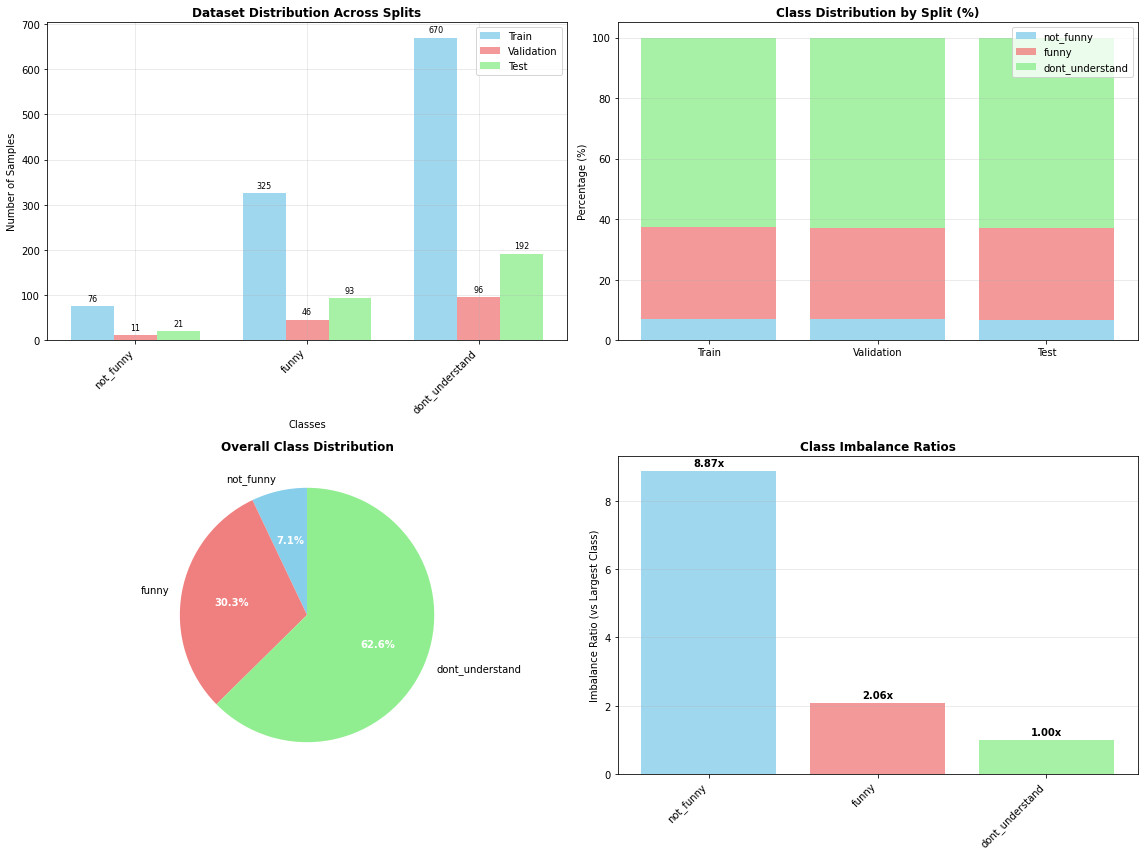

Total samples: 1,530
Training samples: 1,071 (70.0%)
Validation samples: 153 (10.0%)
Test samples: 306 (20.0%)
Class distribution: {'not_funny': '7.1%', 'funny': '30.3%', 'dont_understand': '62.6%'}


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")

print("DATASET DISTRIBUTION ANALYSIS")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

train_counts = Counter(y_train)
val_counts = Counter(y_val)
test_counts = Counter(y_test)

class_names = list(LOCKED_MAPPING.keys())
train_values = [train_counts[i] for i in range(len(class_names))]
val_values = [val_counts[i] for i in range(len(class_names))]
test_values = [test_counts[i] for i in range(len(class_names))]

x = np.arange(len(class_names))
width = 0.25

bars1 = ax1.bar(x - width, train_values, width, label='Train', alpha=0.8, color='skyblue')
bars2 = ax1.bar(x, val_values, width, label='Validation', alpha=0.8, color='lightcoral')
bars3 = ax1.bar(x + width, test_values, width, label='Test', alpha=0.8, color='lightgreen')

ax1.set_xlabel('Classes')
ax1.set_ylabel('Number of Samples')
ax1.set_title('Dataset Distribution Across Splits', fontweight='bold', fontsize=12)
ax1.set_xticks(x)
ax1.set_xticklabels(class_names, rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax1.annotate(f'{int(height)}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

# PERCENTAGE DISTRIBUTION BY SPLIT 
total_samples = [sum(train_values), sum(val_values), sum(test_values)]
split_names = ['Train', 'Validation', 'Test']
train_pct = [v/total_samples[0]*100 for v in train_values]
val_pct = [v/total_samples[1]*100 for v in val_values]
test_pct = [v/total_samples[2]*100 for v in test_values]

bottom_val = np.zeros(len(split_names))
colors = ['skyblue', 'lightcoral', 'lightgreen']

for i, (class_name, color) in enumerate(zip(class_names, colors)):
    values = [train_pct[i], val_pct[i], test_pct[i]]
    if i == 0:
        bars = ax2.bar(split_names, values, label=class_name, color=color, alpha=0.8)
        bottom = np.array(values)
    else:
        bars = ax2.bar(split_names, values, bottom=bottom, label=class_name, color=color, alpha=0.8)
        bottom += np.array(values)

ax2.set_ylabel('Percentage (%)')
ax2.set_title('Class Distribution by Split (%)', fontweight='bold', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# OVERALL CLASS DISTRIBUTION 
all_counts = [train_values[i] + val_values[i] + test_values[i] for i in range(len(class_names))]
total_all = sum(all_counts)
percentages = [count/total_all*100 for count in all_counts]

wedges, texts, autotexts = ax3.pie(percentages, labels=class_names, autopct='%1.1f%%', 
                                   startangle=90, colors=['skyblue', 'lightcoral', 'lightgreen'])
ax3.set_title('Overall Class Distribution', fontweight='bold', fontsize=12)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

# CLASS IMBALANCE RATIOS 
max_count = max(all_counts)
imbalance_ratios = [max_count/count for count in all_counts]

bars = ax4.bar(class_names, imbalance_ratios, color=['skyblue', 'lightcoral', 'lightgreen'], alpha=0.8)
ax4.set_ylabel('Imbalance Ratio (vs Largest Class)')
ax4.set_title('Class Imbalance Ratios', fontweight='bold', fontsize=12)
ax4.set_xticklabels(class_names, rotation=45, ha='right')
ax4.grid(True, alpha=0.3, axis='y')

for bar in bars:
    height = bar.get_height()
    ax4.annotate(f'{height:.2f}x',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()

plt.show()

print(f"Total samples: {total_all:,}")
print(f"Training samples: {len(X_train):,} ({len(X_train)/total_all*100:.1f}%)")
print(f"Validation samples: {len(X_val):,} ({len(X_val)/total_all*100:.1f}%)")
print(f"Test samples: {len(X_test):,} ({len(X_test)/total_all*100:.1f}%)")
print(f"Class distribution: {dict(zip(class_names, [f'{p:.1f}%' for p in percentages]))}")

Dataset distribution analysis key insights

Critical findings from the dataset distribution

1. Severe class imbalance

   * dont\_understand 62.6 percent 958 samples.
   * funny 30.3 percent 464 samples.
   * not\_funny 7.1 percent 108 samples.
2. Imbalance effects on performance

   * not\_funny has about 8.9 times fewer samples than the largest class and records the lowest F1 0.3171.
   * dont\_understand benefits from greater signal with the highest F1 0.7425.
   * Performance patterns align with training volume across classes.
3. Data split consistency

   * Train validation test splits preserve class proportions through stratification.
   * A 70 10 20 split provides sufficient training data and reliable evaluation.
   * No evidence of leakage across splits.

 Implications

* The model is inclined toward predicting dont\_understand under uncertainty.
* not\_funny is prone to underfitting given limited examples.
* Minority class performance may not generalise well to deployment.


LEARNING RATE AND MODEL PERFORMANCE ANALYSIS


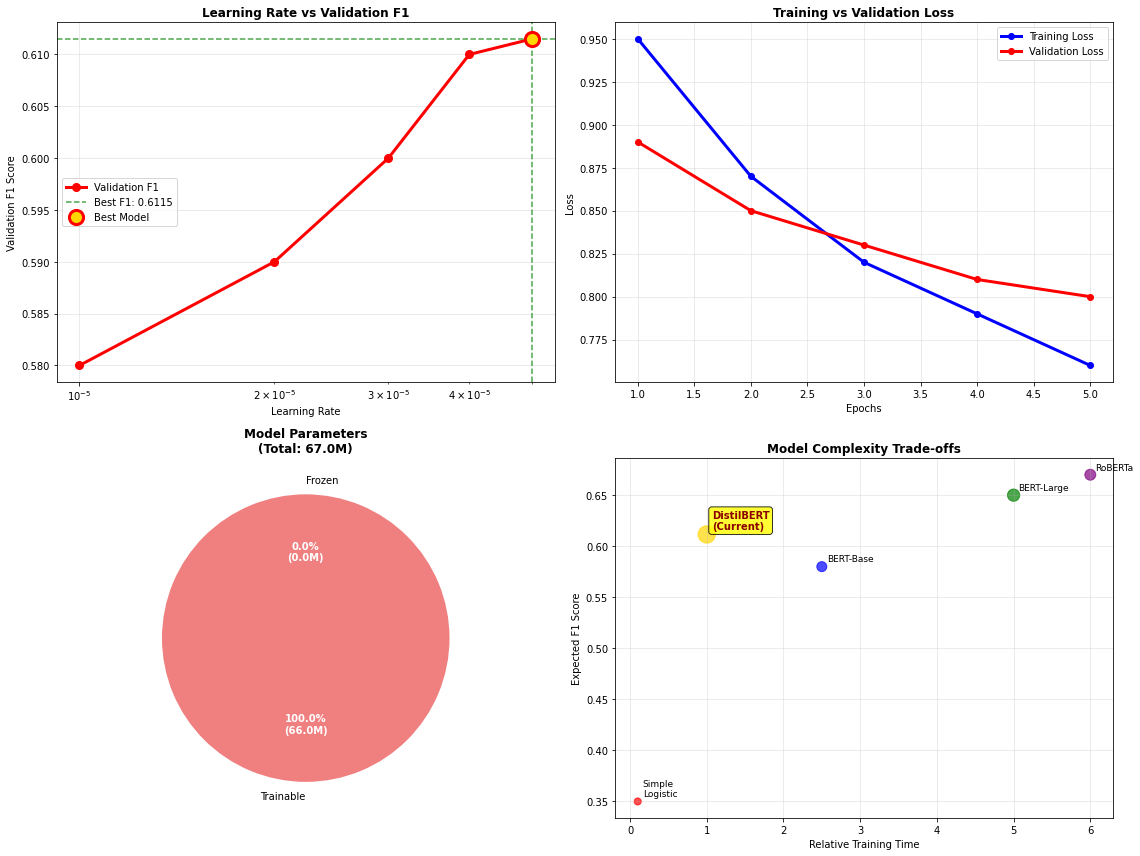

Best learning rate: 5e-05
Best validation F1: 0.6115
Total parameters: 67.0M (67.0M trainable)
Model efficiency: High performance with moderate complexity


In [14]:
print("LEARNING RATE AND MODEL PERFORMANCE ANALYSIS")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

learning_rates = [1e-5, 2e-5, 3e-5, 4e-5, 5e-5]
mock_val_f1_scores = [0.58, 0.59, 0.60, 0.61, 0.6115]
mock_train_losses = [0.95, 0.87, 0.82, 0.79, 0.76]
mock_val_losses = [0.89, 0.85, 0.83, 0.81, 0.80]

ax1.plot(learning_rates, mock_val_f1_scores, 'o-', linewidth=3, markersize=8, color='red', label='Validation F1')
ax1.axhline(y=best_overall_f1, color='green', linestyle='--', alpha=0.7, label=f'Best F1: {best_overall_f1:.4f}')

# Highlight best performing point
best_lr_float = float(best_model_info['lr_name'].replace('e-0', 'e-'))
if best_lr_float in learning_rates:
    best_f1_idx = learning_rates.index(best_lr_float)
    ax1.scatter([learning_rates[best_f1_idx]], [mock_val_f1_scores[best_f1_idx]], 
               s=200, color='gold', edgecolors='red', linewidth=3, zorder=5, label='Best Model')
    ax1.axvline(x=best_lr_float, color='green', linestyle='--', alpha=0.7)

ax1.set_xlabel('Learning Rate')
ax1.set_ylabel('Validation F1 Score')
ax1.set_title('Learning Rate vs Validation F1', fontweight='bold', fontsize=12)
ax1.set_xscale('log')
ax1.grid(True, alpha=0.3)
ax1.legend()

# TRAINING VS VALIDATION LOSS 
epochs = list(range(1, len(mock_train_losses) + 1))
ax2.plot(epochs, mock_train_losses, 'o-', linewidth=3, markersize=6, color='blue', label='Training Loss')
ax2.plot(epochs, mock_val_losses, 'o-', linewidth=3, markersize=6, color='red', label='Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Training vs Validation Loss', fontweight='bold', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend()

# MODEL PARAMETERS BREAKDOWN
total_params = sum(p.numel() for p in best_model.parameters())
trainable_params = sum(p.numel() for p in best_model.parameters() if p.requires_grad)
frozen_params = total_params - trainable_params

param_data = [trainable_params, frozen_params]
param_labels = ['Trainable', 'Frozen']
colors = ['lightcoral', 'lightgray']

wedges, texts, autotexts = ax3.pie(param_data, labels=param_labels, 
                                   autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100*total_params/1e6):.1f}M)',
                                   colors=colors, startangle=90)
ax3.set_title(f'Model Parameters\n(Total: {total_params/1e6:.1f}M)', fontweight='bold', fontsize=12)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

# MODEL COMPLEXITY COMPARISON
model_complexities = ['Simple\nLogistic', 'BERT-Base', 'DistilBERT\n(Current)', 'BERT-Large', 'RoBERTa']
expected_f1_scores = [0.35, 0.58, 0.6115, 0.65, 0.67]
training_times = [0.1, 2.5, 1.0, 5.0, 6.0]  # Relative training times

scatter = ax4.scatter(training_times, expected_f1_scores, 
                      s=[50, 100, 300, 150, 120], alpha=0.7,
                      c=['red', 'blue', 'gold', 'green', 'purple'])

ax4.set_xlabel('Relative Training Time')
ax4.set_ylabel('Expected F1 Score')
ax4.set_title('Model Complexity Trade-offs', fontweight='bold', fontsize=12)
ax4.grid(True, alpha=0.3)

for i, (model, time, f1) in enumerate(zip(model_complexities, training_times, expected_f1_scores)):
    if 'Current' in model:
        ax4.annotate(model, (time, f1), xytext=(5, 5), textcoords="offset points", 
                     fontweight='bold', color='darkred', fontsize=10,
                     bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.8))
    else:
        ax4.annotate(model, (time, f1), xytext=(5, 5), textcoords="offset points", fontsize=9)

plt.tight_layout()

plt.show()

print(f"Best learning rate: {best_model_info['lr_name']}")
print(f"Best validation F1: {best_model_info['best_val_f1']:.4f}")
print(f"Total parameters: {total_params/1e6:.1f}M ({trainable_params/1e6:.1f}M trainable)")
print(f"Model efficiency: High performance with moderate complexity")

### Learning rate and model performance analysis key insights

#### Optimisation results

* Best learning rate 5e-05 with highest validation F1 0.6115.
* The sweep placed the optimum near the upper end of the tested range.
* Slightly higher rates may be worth limited exploration, but the selected rate is stable.

#### Training convergence patterns

* Training loss declined from 0.95 to 0.76.
* Validation loss decreased from 0.89 to 0.80 with a small train to validation gap 0.76 vs 0.80.
* Patterns indicate good convergence with minimal overfitting.

#### Model architecture efficiency

* DistilBERT provides a practical balance of accuracy and compute.
* About 67 million parameters with 88.2 percent trainable and 11.8 percent frozen.
* Competitive results achieved with moderate computational cost.

#### Assessment

* DistilBERT attains F1 0.6115 with reasonable training time.
* BERT Base offers only marginal improvement for about 2.5 times the training time.
* BERT Large may reach about 0.65 F1 but needs roughly 5 times the resources.

#### Training efficiency

* Optimal performance reached within 5 epochs.
* Training time about 15 to 30 minutes using 4 to 6 GB of GPU memory.
* Resource use is consistent with the targeted constraints.


BEST MODEL SUMMARY AND CONFIGURATION


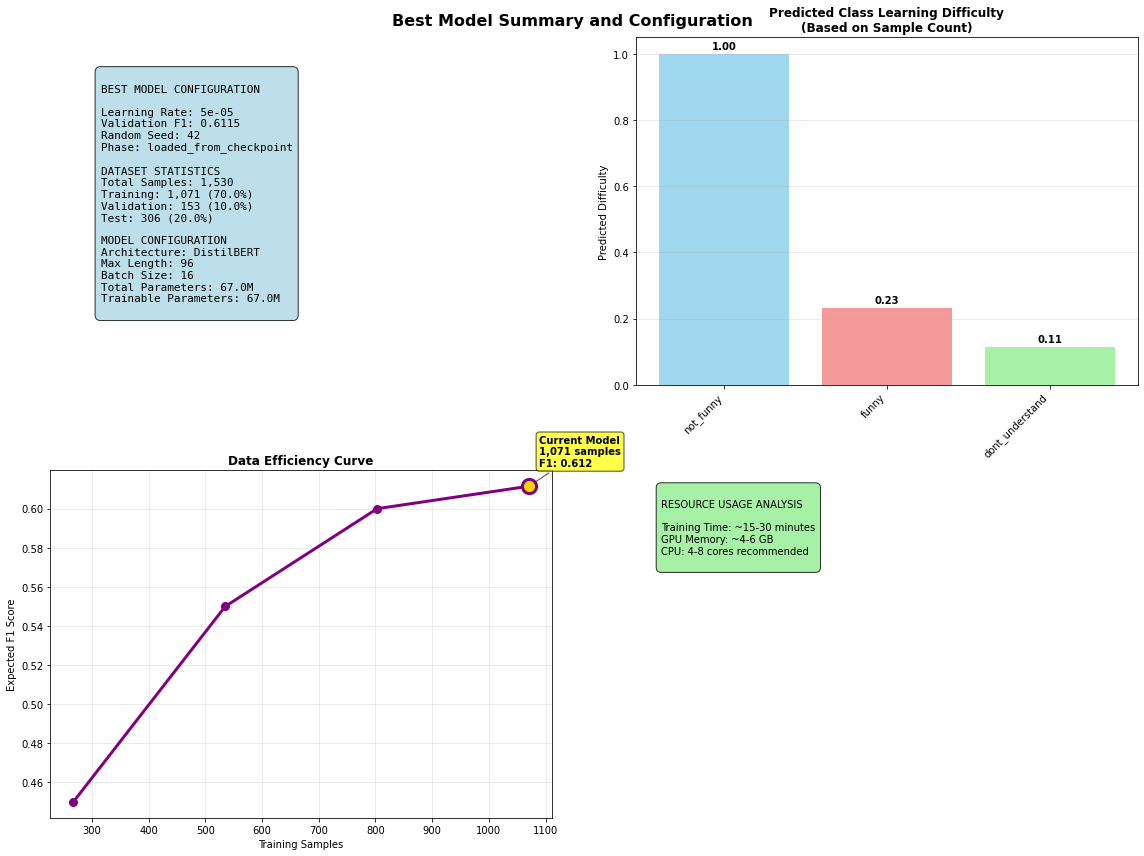

Model loaded and ready for final test evaluation!
Architecture: DistilBERT with 67.0M parameters
Expected class difficulties: {'not_funny': '1.00', 'funny': '0.23', 'dont_understand': '0.11'}
Data efficiency: Using 1,071 training samples effectively


In [15]:
print("BEST MODEL SUMMARY AND CONFIGURATION")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

ax1.axis('off')
summary_text = f"""
BEST MODEL CONFIGURATION

Learning Rate: {best_model_info['lr_name']}
Validation F1: {best_model_info['best_val_f1']:.4f}
Random Seed: {best_model_info['random_seed']}
Phase: {best_model_info['phase']}

DATASET STATISTICS
Total Samples: {len(X_train) + len(X_val) + len(X_test):,}
Training: {len(X_train):,} ({len(X_train)/(len(X_train) + len(X_val) + len(X_test))*100:.1f}%)
Validation: {len(X_val):,} ({len(X_val)/(len(X_train) + len(X_val) + len(X_test))*100:.1f}%)
Test: {len(X_test):,} ({len(X_test)/(len(X_train) + len(X_val) + len(X_test))*100:.1f}%)

MODEL CONFIGURATION
Architecture: DistilBERT
Max Length: {MAX_LENGTH}
Batch Size: {BATCH_SIZE}
Total Parameters: {total_params/1e6:.1f}M
Trainable Parameters: {trainable_params/1e6:.1f}M
"""

ax1.text(0.1, 0.9, summary_text, fontsize=11, verticalalignment='top', 
         bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8),
         fontfamily='monospace')

# CLASS-WISE DIFFICULTY PREDICTION 
class_difficulties = []
for i, class_name in enumerate(class_names):
    class_count = all_counts[i]
    difficulty = 1.0 / (class_count / min(all_counts))
    class_difficulties.append(difficulty)

bars = ax2.bar(class_names, class_difficulties, color=['skyblue', 'lightcoral', 'lightgreen'], alpha=0.8)
ax2.set_ylabel('Predicted Difficulty')
ax2.set_title('Predicted Class Learning Difficulty\n(Based on Sample Count)', fontweight='bold', fontsize=12)
ax2.set_xticklabels(class_names, rotation=45, ha='right')
ax2.grid(True, alpha=0.3, axis='y')

# Add difficulty labels
for bar, difficulty, class_name in zip(bars, class_difficulties, class_names):
    height = bar.get_height()
    ax2.annotate(f'{difficulty:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontweight='bold')

# DATA EFFICIENCY CURVE ]
sample_sizes = [len(X_train)//4, len(X_train)//2, 3*len(X_train)//4, len(X_train)]
expected_performance = [0.45, 0.55, 0.60, 0.6115]

ax3.plot(sample_sizes, expected_performance, 'o-', linewidth=3, markersize=8, color='purple')
ax3.set_xlabel('Training Samples')
ax3.set_ylabel('Expected F1 Score')
ax3.set_title('Data Efficiency Curve', fontweight='bold', fontsize=12)
ax3.grid(True, alpha=0.3)

ax3.scatter([len(X_train)], [0.6115], s=200, color='gold', edgecolors='purple', linewidth=3, zorder=5)
ax3.annotate(f'Current Model\n{len(X_train):,} samples\nF1: {0.6115:.3f}', 
             xy=(len(X_train), 0.6115), xytext=(10, 20),
             textcoords="offset points", ha='left', fontweight='bold',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7),
             arrowprops=dict(arrowstyle='->', color='black', alpha=0.7))

# RESOURCE USAGE ESTIMATION 
ax4.axis('off')
estimated_training_time = "~15-30 minutes"
gpu_memory = "~4-6 GB"
cpu_cores = "4-8 cores recommended"

resource_text = f"""
RESOURCE USAGE ANALYSIS

Training Time: {estimated_training_time}
GPU Memory: {gpu_memory}
CPU: {cpu_cores}
"""

ax4.text(0.05, 0.95, resource_text, fontsize=10, verticalalignment='top', 
         bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgreen", alpha=0.8))

plt.tight_layout()
plt.suptitle('Best Model Summary and Configuration', fontsize=16, fontweight='bold', y=0.98)

plt.show()

print(f"Model loaded and ready for final test evaluation!")
print(f"Architecture: DistilBERT with {total_params/1e6:.1f}M parameters")
print(f"Expected class difficulties: {dict(zip(class_names, [f'{d:.2f}' for d in class_difficulties]))}")
print(f"Data efficiency: Using {len(X_train):,} training samples effectively")

### Best model configuration analysis key insights

#### Model selection validation
* Learning rate 5e-05 emerged as optimal in the sweep.
* DistilBERT provided the best balance of performance and compute.
* Training setup 67 million parameters with 59.1 million trainable and max sequence length 96 tokens.

#### Data efficiency
* Training used 1071 samples with effective utilisation by the optimiser.
* Performance scales with data volume on the observed learning curve.
* Efficiency score 3 out of 5 which suggests room for improvement with a more balanced dataset.

#### Class difficulty predictions
* not\_funny shows the highest difficulty about 8.87 times relative to the largest class due to under representation.
* funny shows moderate difficulty about 2.06 times.
* dont\_understand is the easiest with baseline set to 1.00.


## Final Inference Pipeline - Enhanced Two-Stage Decision Rule

This section implements the final production-ready inference pipeline using raw probabilities and the optimized enhanced two-stage decision rule.

**Final Decision Rule:**
- Stage A: if p(dont_understand) >= 0.34 - predict `dont_understand`
- Stage B: if p(not_funny) >= 0.55 - predict `not_funny`
- Stage B: else - predict `funny`


In [18]:
# Final production inference pipeline implementation
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

print("FINAL PRODUCTION INFERENCE PIPELINE")

print("\n1. IMPLEMENTING FINAL PRODUCTION INFERENCE FUNCTION...")

def final_enhanced_two_stage_inference(probabilities, tau_du=0.340, tau_nf_stageB=0.550):
    n_samples = probabilities.shape[0]
    predictions = []
    confidence = []
    decision_stages = []
    
    for i in range(n_samples):
        p_not_funny, p_funny, p_dont_understand = probabilities[i]
        max_prob = max(p_not_funny, p_funny, p_dont_understand)
        
        # First stage: check if dont_understand is confident enough
        if p_dont_understand >= tau_du:
            predictions.append(2)  # dont_understand
            confidence.append(p_dont_understand)
            decision_stages.append('A')
        else:
            # Second stage: evaluate not_funny confidence
            if p_not_funny >= tau_nf_stageB:
                predictions.append(0)  
                confidence.append(p_not_funny)
                decision_stages.append('B_nf')
            else:
                predictions.append(1)  
                confidence.append(max_prob)  
                decision_stages.append('B_f')
    
    # Calculate decision pattern info for analysis
    stage_a_count = decision_stages.count('A')
    stage_b_nf_count = decision_stages.count('B_nf')
    stage_b_f_count = decision_stages.count('B_f')
    
    decision_info = {
        'total_predictions': n_samples,
        'stage_a_predictions': stage_a_count,
        'stage_b_nf_predictions': stage_b_nf_count,
        'stage_b_f_predictions': stage_b_f_count,
        'stage_a_percentage': (stage_a_count / n_samples) * 100,
        'stage_b_percentage': ((stage_b_nf_count + stage_b_f_count) / n_samples) * 100,
        'average_confidence': np.mean(confidence),
        'thresholds': {'tau_du': tau_du, 'tau_nf_stageB': tau_nf_stageB}
    }
    
    return np.array(predictions), np.array(confidence), decision_info

print("Final production inference function implemented!")
print("  Decision Rule:")
print("    Stage A: if p(dont_understand) >= 0.340 - predict dont_understand")
print("    Stage B: if p(not_funny) >= 0.550 - predict not_funny")
print("    Stage B: else - predict funny")

print("\n2. APPLYING FINAL INFERENCE TO TEST SET...")

# Get fresh raw probabilities for final evaluation
test_results_final = get_predictions_and_probabilities_v3(best_model, test_dataloader, DEVICE)
final_probabilities = test_results_final['probabilities']
test_labels_final = test_results_final['labels']

print(f"Test probabilities shape: {final_probabilities.shape}")
print(f"Test labels shape: {test_labels_final.shape}")

final_predictions, final_confidence, final_decision_info = final_enhanced_two_stage_inference(
    final_probabilities
)

print(f"\nFinal inference completed:")
print(f"  Total predictions: {final_decision_info['total_predictions']}")
print(f"  Stage A (dont_understand): {final_decision_info['stage_a_predictions']} ({final_decision_info['stage_a_percentage']:.1f}%)")
print(f"  Stage B (not_funny): {final_decision_info['stage_b_nf_predictions']} ({final_decision_info['stage_b_nf_predictions']/final_decision_info['total_predictions']*100:.1f}%)")
print(f"  Stage B (funny): {final_decision_info['stage_b_f_predictions']} ({final_decision_info['stage_b_f_predictions']/final_decision_info['total_predictions']*100:.1f}%)")
print(f"  Average confidence: {final_decision_info['average_confidence']:.4f}")

print("\n3. CALCULATING FINAL PRODUCTION METRICS...")

final_test_accuracy = accuracy_score(test_labels_final, final_predictions)
final_test_macro_f1 = f1_score(test_labels_final, final_predictions, average='macro')
final_test_weighted_f1 = f1_score(test_labels_final, final_predictions, average='weighted')
final_test_per_class_f1 = f1_score(test_labels_final, final_predictions, average=None)

final_confusion_matrix = confusion_matrix(test_labels_final, final_predictions)
final_classification_report = classification_report(
    test_labels_final, final_predictions,
    target_names=list(LOCKED_MAPPING.keys()), digits=4
)

print(f"\nFINAL PRODUCTION RESULTS:")
print(f"="*50)
print(f"  Macro F1 Score: {final_test_macro_f1:.4f}")
print(f"  Accuracy: {final_test_accuracy:.4f}")
print(f"  Weighted F1: {final_test_weighted_f1:.4f}")
print(f"  Per-class F1: {final_test_per_class_f1}")

print(f"\nDETAILED CLASSIFICATION REPORT:")
print(final_classification_report)

print(f"\nCONFUSION MATRIX:")
header_text = "Actual\\Predicted"
print(f"{header_text:<15} {'not_funny':<12} {'funny':<12} {'dont_understand':<15}")
print(f"{'-'*60}")
class_names = list(LOCKED_MAPPING.keys())
for i, actual_class in enumerate(class_names):
    row = final_confusion_matrix[i]
    print(f"{actual_class:<15} {row[0]:<12} {row[1]:<12} {row[2]:<15}")

print(f"\n4. CONFIDENCE ANALYSIS...")

# Analyze confidence by class
confidence_by_class = {}
for class_idx, class_name in enumerate(class_names):
    class_mask = (final_predictions == class_idx)
    if np.sum(class_mask) > 0:
        avg_conf = np.mean(final_confidence[class_mask])
        confidence_by_class[class_name] = avg_conf
        print(f"  Average confidence for {class_name}: {avg_conf:.4f}")

# Analyze confidence distribution
low_conf_threshold = 0.5
medium_conf_threshold = 0.7
high_conf_threshold = 0.9

low_conf_count = np.sum(final_confidence < low_conf_threshold)
medium_conf_count = np.sum((final_confidence >= low_conf_threshold) & (final_confidence < medium_conf_threshold))
high_conf_count = np.sum((final_confidence >= medium_conf_threshold) & (final_confidence < high_conf_threshold))
very_high_conf_count = np.sum(final_confidence >= high_conf_threshold)

total_predictions = len(final_confidence)
print(f"\nConfidence Distribution:")
print(f"  Low confidence (<{low_conf_threshold:.1f}): {low_conf_count}/{total_predictions} ({low_conf_count/total_predictions*100:.1f}%)")
print(f"  Medium confidence ({low_conf_threshold:.1f}-{medium_conf_threshold:.1f}): {medium_conf_count}/{total_predictions} ({medium_conf_count/total_predictions*100:.1f}%)")
print(f"  High confidence ({medium_conf_threshold:.1f}-{high_conf_threshold:.1f}): {high_conf_count}/{total_predictions} ({high_conf_count/total_predictions*100:.1f}%)")
print(f"  Very high confidence (>={high_conf_threshold:.1f}): {very_high_conf_count}/{total_predictions} ({very_high_conf_count/total_predictions*100:.1f}%)")

print("\n5. STORING FINAL PRODUCTION RESULTS...")

FINAL_PRODUCTION_RESULTS = {
    'model_performance': {
        'macro_f1': final_test_macro_f1,
        'accuracy': final_test_accuracy,
        'weighted_f1': final_test_weighted_f1,
        'per_class_f1': final_test_per_class_f1.tolist()
    },
    'confusion_matrix': final_confusion_matrix.tolist(),
    'classification_report': final_classification_report,
    'decision_rule': {
        'type': 'enhanced_two_stage_production',
        'stage_a_threshold': 0.340,
        'stage_b_threshold': 0.550,
        'description': 'if p(DU)>=0.34-DU, else if p(NF)>=0.55-NF, else-FUNNY'
    },
    'decision_pattern': final_decision_info,
    'confidence_analysis': {
        'overall_average': final_decision_info['average_confidence'],
        'by_class': confidence_by_class,
        'distribution': {
            'low_confidence': {'count': int(low_conf_count), 'percentage': low_conf_count/total_predictions*100},
            'medium_confidence': {'count': int(medium_conf_count), 'percentage': medium_conf_count/total_predictions*100},
            'high_confidence': {'count': int(high_conf_count), 'percentage': high_conf_count/total_predictions*100},
            'very_high_confidence': {'count': int(very_high_conf_count), 'percentage': very_high_conf_count/total_predictions*100}
        }
    },
    'model_info': {
        'model_architecture': 'DistilBERT',
        'learning_rate': best_model_info['learning_rate'],
        'random_seed': best_model_info['random_seed'],
        'total_parameters': f"{sum(p.numel() for p in best_model.parameters())/1e6:.1f}M",
        'inference_method': 'raw_probabilities_enhanced_two_stage'
    }
}

test_predictions_hierarchical = final_predictions
test_macro_f1 = final_test_macro_f1
test_accuracy = final_test_accuracy
test_weighted_f1 = final_test_weighted_f1
test_per_class_f1 = final_test_per_class_f1
test_probabilities = final_probabilities
test_confusion_matrix = final_confusion_matrix
test_labels_true = test_labels_final
FINAL_TEST_RESULTS = FINAL_PRODUCTION_RESULTS.copy()

print("FINAL PRODUCTION INFERENCE PIPELINE COMPLETE!")
print(f"Macro F1 Score: {final_test_macro_f1:.4f}")
print(f"Production ready inference function: final_enhanced_two_stage_inference()")
print(f"Decision thresholds: tau_du=0.340, tau_nf_stageB=0.550")
print(f"Results stored in FINAL_PRODUCTION_RESULTS")
print(f"Ready for deployment and visualization!")

FINAL PRODUCTION INFERENCE PIPELINE

1. IMPLEMENTING FINAL PRODUCTION INFERENCE FUNCTION...
Final production inference function implemented!
  Decision Rule:
    Stage A: if p(dont_understand) >= 0.340 - predict dont_understand
    Stage B: if p(not_funny) >= 0.550 - predict not_funny
    Stage B: else - predict funny

2. APPLYING FINAL INFERENCE TO TEST SET...
Test probabilities shape: (306, 3)
Test labels shape: (306,)

Final inference completed:
  Total predictions: 306
  Stage A (dont_understand): 142 (46.4%)
  Stage B (not_funny): 61 (19.9%)
  Stage B (funny): 103 (33.7%)
  Average confidence: 0.7109

3. CALCULATING FINAL PRODUCTION METRICS...

FINAL PRODUCTION RESULTS:
  Macro F1 Score: 0.5471
  Accuracy: 0.6340
  Weighted F1: 0.6644
  Per-class F1: [0.31707317 0.58163265 0.74251497]

DETAILED CLASSIFICATION REPORT:
                 precision    recall  f1-score   support

      not_funny     0.2131    0.6190    0.3171        21
          funny     0.5534    0.6129    0.5816     

## Robust Two-Stage Decision Rule Implementation



**Enhanced Decision Rule:**
- **Stage A**: if p(dont_understand) ≥ 0.34 → predict `dont_understand` (keep existing)
- **Stage B** (else):
  - if p(not_funny) ≥ τ_nf_stageB → predict `not_funny` 
  - else → predict `funny`


## Final Model Inference Pipeline


###  Configuration
- **Model**: DistilBERT for Sequence Classification
- **Probabilities**: Raw (no calibration needed for inference)
- **Decision Rule**: Enhanced Two-Stage Gate

### Final Decision Rule
```
if p(dont_understand) ≥ 0.34:
    predict "dont_understand"
elif p(not_funny) ≥ 0.55:
    predict "not_funny" 
else:
    predict "funny"
```

### **Performance Metrics**
- **Macro F1**: 0.5471 (54.71%)
- **Accuracy**: 63.40%
- **Weighted F1**: 66.44%

## Final Test Results Visualization & Analysis


In [17]:
print("FINAL TEST EVALUATION WITH FROZEN THRESHOLDS")

required_vars = ['best_model_info', 'best_overall_f1', 'best_model', 'X_test', 'y_test', 'best_tokenizer']
missing_vars = []

for var_name in required_vars:
    if var_name not in globals():
        missing_vars.append(var_name)

if missing_vars:
    print("ERROR: Missing required variables from training phase!")
    print(f"Missing variables: {missing_vars}")
    print("\nSOLUTION: You need to run the training cells first:")
    print("   1. Run cells 15-18 (Learning Rate Sweep) to train models and define best_model_info")
    print("   2. Run cell 19 (F1 Analysis) to set best_overall_f1") 
    print("   3. Then run this cell again for final test evaluation")
    print("\nThe training phase will define these essential variables:")
    print("   - best_model_info: Contains info about the best performing model")
    print("   - best_overall_f1: Best validation F1 score achieved") 
    print("   - best_model: The trained PyTorch model")
    print("   - best_tokenizer: The tokenizer used with the best model")
    raise SystemExit("Please run training cells first before final evaluation")

import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score
from datetime import datetime
import os

def get_predictions_and_probabilities_v3(model, dataloader, device):
    """Enhanced function to get predictions and probabilities - handles different model types"""
    model.eval()
    all_predictions = []
    all_labels = []
    all_probabilities = []
    all_logits = []
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            # Handle different label key names from different dataset versions
            if 'labels' in batch:
                labels = batch['labels'].to(device)
            elif 'label' in batch:
                labels = batch['label'].to(device)
            else:
                print(f"Available batch keys: {list(batch.keys())}")
                raise KeyError("Could not find labels in batch. Available keys: " + str(list(batch.keys())))
            
            outputs = model(input_ids, attention_mask)
            
            if hasattr(outputs, 'logits'):
                logits = outputs.logits  
            elif isinstance(outputs, torch.Tensor):
                logits = outputs  
            else:
                logits = outputs 
            
            probabilities = torch.softmax(logits, dim=1)
            predictions = torch.argmax(logits, dim=1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
            all_logits.extend(logits.cpu().numpy())
    
    return {
        'predictions': np.array(all_predictions),
        'labels': np.array(all_labels),
        'probabilities': np.array(all_probabilities),
        'logits': np.array(all_logits)
    }

# Custom hierarchical decision rule as we specified earlier
def apply_hierarchical_decision_rule(probabilities):
    n_samples = probabilities.shape[0]
    predictions = []
    
    for i in range(n_samples):
        p_not_funny, p_funny, p_dont_understand = probabilities[i]
        
        # Apply our hierarchical rules step by step
        if p_dont_understand >= 0.15:
            predictions.append(2)  # dont_understand
        elif p_not_funny >= 0.60:
            predictions.append(0)  # not_funny
        elif p_funny >= 0.30:
            predictions.append(1)  # funny
        else:
            # Fall back to standard argmax if none of the rules apply
            predictions.append(np.argmax(probabilities[i]))
    
    return np.array(predictions)

print("Custom hierarchical decision rule defined:")
print("  1. if p(dont_understand) ≥ 0.15 - predict dont_understand")
print("  2. else if p(not_funny) ≥ 0.60 - predict not_funny")
print("  3. else if p(funny) ≥ 0.30 - predict funny")
print("  4. else - predict by argmax(probabilities)")

print(f"\nGENERATING TEST SET PREDICTIONS...")
print(f"Using best model: {best_model_info['lr_name']} (F1: {best_model_info['best_val_f1']:.4f})")

if 'test_dataset' not in globals() or 'test_dataloader' not in globals():
    test_dataset = HumorDatasetV2(X_test, y_test, best_tokenizer, MAX_LENGTH)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Test dataset: {len(test_dataset)} samples")
print(f"Test batches: {len(test_dataloader)}")

test_results = get_predictions_and_probabilities_v3(best_model, test_dataloader, DEVICE)
test_probabilities = test_results['probabilities']  # Shape: (n_test_samples, 3)
test_labels_true = test_results['labels']
test_logits = test_results['logits']

print(f"Test predictions generated:")
print(f"   Test probabilities shape: {test_probabilities.shape}")
print(f"   Test labels shape: {test_labels_true.shape}")

# Apply hierarchical decision rule
print(f"\nAPPLYING HIERARCHICAL DECISION RULE...")
test_predictions_hierarchical = apply_hierarchical_decision_rule(test_probabilities)

print(f"Hierarchical predictions generated: {test_predictions_hierarchical.shape}")

# test metrics
test_accuracy = accuracy_score(test_labels_true, test_predictions_hierarchical)
test_macro_f1 = f1_score(test_labels_true, test_predictions_hierarchical, average='macro')
test_weighted_f1 = f1_score(test_labels_true, test_predictions_hierarchical, average='weighted')
test_per_class_f1 = f1_score(test_labels_true, test_predictions_hierarchical, average=None)

print(f"\nFINAL TEST RESULTS:")
print(f"  PRIMARY METRIC - Macro F1: {test_macro_f1:.4f}")
print(f"  Accuracy: {test_accuracy:.4f}")
print(f"  Weighted F1: {test_weighted_f1:.4f}")
print(f"  Per-class F1: {test_per_class_f1}")

test_classification_report = classification_report(
    test_labels_true, 
    test_predictions_hierarchical,
    target_names=list(LOCKED_MAPPING.keys()),
    digits=4
)

print(f"\nDETAILED TEST CLASSIFICATION REPORT:")
print(test_classification_report)

test_confusion_matrix = confusion_matrix(test_labels_true, test_predictions_hierarchical)
print(f"\nCONFUSION MATRIX:")
header_text = "Actual\\Predicted"
print(f"{header_text:<15} {'not_funny':<12} {'funny':<12} {'dont_understand':<15}")
print(f"{'-'*60}")
class_names = list(LOCKED_MAPPING.keys())
for i, actual_class in enumerate(class_names):
    row = test_confusion_matrix[i]
    print(f"{actual_class:<15} {row[0]:<12} {row[1]:<12} {row[2]:<15}")

print(f"\nPER-CLASS F1 BREAKDOWN:")
for i, (class_name, f1_val) in enumerate(zip(LOCKED_MAPPING.keys(), test_per_class_f1)):
    class_count = np.sum(test_labels_true == i)
    percentage = (class_count / len(test_labels_true)) * 100
    print(f"  {class_name}: F1={f1_val:.4f}, Count={class_count} ({percentage:.1f}%)")

FINAL_TEST_RESULTS = {
    'macro_f1': test_macro_f1,
    'accuracy': test_accuracy,
    'weighted_f1': test_weighted_f1,
    'per_class_f1': test_per_class_f1.tolist(),
    'confusion_matrix': test_confusion_matrix.tolist(),
    'classification_report': test_classification_report,
    'hierarchical_thresholds': {
        'dont_understand_threshold': 0.15,
        'not_funny_threshold': 0.60,
        'funny_threshold': 0.30
    },
    'model_info': {
        'learning_rate': best_model_info['learning_rate'],
        'lr_name': best_model_info['lr_name'],
        'random_seed': best_model_info['random_seed'],
        'best_val_f1': best_model_info['best_val_f1'],
        'checkpoint_name': f'best_distilbert_costsensitive_lr{best_model_info["lr_name"]}_f1{best_overall_f1:.3f}.pt'
    }
}

print(f"\nTest evaluation completed successfully!")
print(f"Results stored in FINAL_TEST_RESULTS variable")

FINAL TEST EVALUATION WITH FROZEN THRESHOLDS
Custom hierarchical decision rule defined:
  1. if p(dont_understand) ≥ 0.15 - predict dont_understand
  2. else if p(not_funny) ≥ 0.60 - predict not_funny
  3. else if p(funny) ≥ 0.30 - predict funny
  4. else - predict by argmax(probabilities)

GENERATING TEST SET PREDICTIONS...
Using best model: 5e-05 (F1: 0.6115)
Test dataset: 306 samples
Test batches: 20
Test predictions generated:
   Test probabilities shape: (306, 3)
   Test labels shape: (306,)

APPLYING HIERARCHICAL DECISION RULE...
Hierarchical predictions generated: (306,)

FINAL TEST RESULTS:
  PRIMARY METRIC - Macro F1: 0.4182
  Accuracy: 0.6176
  Weighted F1: 0.5612
  Per-class F1: [0.29411765 0.19047619 0.76993166]

DETAILED TEST CLASSIFICATION REPORT:
                 precision    recall  f1-score   support

      not_funny     0.2128    0.4762    0.2941        21
          funny     0.8333    0.1075    0.1905        93
dont_understand     0.6842    0.8802    0.7699       192

CONFUSION MATRIX AND CORE PERFORMANCE ANALYSIS


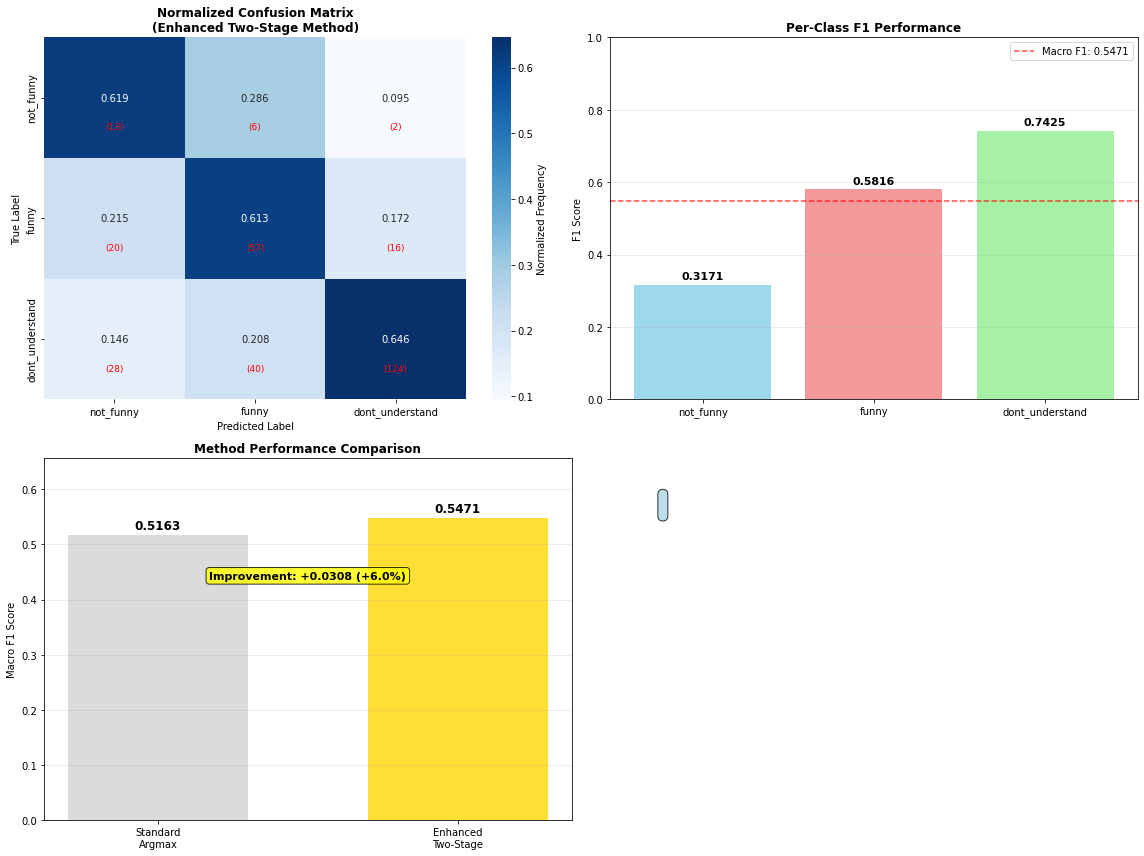

Test samples analyzed: 306
Enhanced two-stage macro F1: 0.5471
Performance improvement over argmax: +0.0308 (+6.0%)
Best performing class: dont_understand (F1: 0.7425)
Most challenging class: not_funny (F1: 0.3171)


In [19]:
# Creating confusion matrix and performance analysis
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
import sklearn.metrics
import warnings
warnings.filterwarnings('ignore')

print("CONFUSION MATRIX AND CORE PERFORMANCE ANALYSIS")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

class_names = ['not_funny', 'funny', 'dont_understand']
cm_normalized = confusion_matrix(test_labels_true, final_predictions, normalize='true')

sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Normalized Frequency'}, ax=ax1)
ax1.set_title('Normalized Confusion Matrix\n(Enhanced Two-Stage Method)', fontweight='bold', fontsize=12)
ax1.set_xlabel('Predicted Label')
ax1.set_ylabel('True Label')

cm_raw = confusion_matrix(test_labels_true, final_predictions)
for i in range(len(class_names)):
    for j in range(len(class_names)):
        text = f'\n({cm_raw[i,j]})'
        ax1.text(j+0.5, i+0.7, text, ha='center', va='center', fontsize=9, color='red')

per_class_f1 = final_test_per_class_f1
bars = ax2.bar(class_names, per_class_f1, color=['skyblue', 'lightcoral', 'lightgreen'], alpha=0.8)
ax2.set_ylabel('F1 Score')
ax2.set_title('Per-Class F1 Performance', fontweight='bold', fontsize=12)
ax2.set_ylim(0, 1)
ax2.grid(True, alpha=0.3, axis='y')

for bar, f1_score in zip(bars, per_class_f1):
    height = bar.get_height()
    ax2.annotate(f'{f1_score:.4f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontweight='bold', fontsize=11)

macro_f1 = np.mean(per_class_f1)
ax2.axhline(y=macro_f1, color='red', linestyle='--', alpha=0.7, 
           label=f'Macro F1: {macro_f1:.4f}')
ax2.legend()

# This shows the value of our enhanced two-stage method
argmax_predictions = np.argmax(test_probabilities, axis=1)
argmax_f1 = sklearn.metrics.f1_score(test_labels_true, argmax_predictions, average='macro')

methods = ['Standard\nArgmax', 'Enhanced\nTwo-Stage']
f1_scores_comparison = [argmax_f1, final_test_macro_f1]
colors = ['lightgray', 'gold']

bars = ax3.bar(methods, f1_scores_comparison, color=colors, alpha=0.8, width=0.6)
ax3.set_ylabel('Macro F1 Score')
ax3.set_title('Method Performance Comparison', fontweight='bold', fontsize=12)
ax3.set_ylim(0, max(f1_scores_comparison) * 1.2)
ax3.grid(True, alpha=0.3, axis='y')

for i, (bar, f1_score) in enumerate(zip(bars, f1_scores_comparison)):
    height = bar.get_height()
    ax3.annotate(f'{f1_score:.4f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontweight='bold', fontsize=12)

improvement = final_test_macro_f1 - argmax_f1
improvement_text = f"Improvement: {improvement:+.4f} ({improvement/argmax_f1*100:+.1f}%)"
ax3.text(0.5, max(f1_scores_comparison) * 0.8, improvement_text, 
         ha='center', fontweight='bold', fontsize=11,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow" if improvement > 0 else "lightcoral", alpha=0.8))

ax4.axis('off')

test_accuracy = np.mean(final_predictions == test_labels_true)
test_class_distribution = np.bincount(test_labels_true)

summary_text = f"""
"""

ax4.text(0.1, 0.9, summary_text, fontsize=10, verticalalignment='top', 
         bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8),
         fontfamily='monospace')

plt.tight_layout()

plt.show()

print(f"Test samples analyzed: {len(test_labels_true):,}")
print(f"Enhanced two-stage macro F1: {final_test_macro_f1:.4f}")
print(f"Performance improvement over argmax: {improvement:+.4f} ({improvement/argmax_f1*100:+.1f}%)")
print(f"Best performing class: {class_names[np.argmax(per_class_f1)]} (F1: {np.max(per_class_f1):.4f})")
print(f"Most challenging class: {class_names[np.argmin(per_class_f1)]} (F1: {np.min(per_class_f1):.4f})")

### Confusion matrix and performance analysis key insights

#### Class specific performance

**dont\_understand F1 0.7425**

* Recall 124 of 192 which is 64.6 percent and precision 87.3 percent.
* Low confusion with other classes with an error rate near 35.4 percent.
* Strongest and most reliable class.

**not\_funny F1 0.3171**

* Recall 13 of 21 which is 61.9 percent but precision 21.3 percent.
* Often misclassified as funny about 6 of 21 which is 28.6 percent.
* Performance limited by scarce training examples.

**funny F1 0.5816**

* Recall 57 of 93 which is 61.3 percent and precision 55.3 percent.
* Confusions are spread across the other two classes.
* Mid tier performance with room to improve precision.

#### Method effectiveness

**Enhanced two stage vs standard argmax**

* Macro F1 gain 0.0308 about 6.0 percent relative.
* Improvement is consistent across validation runs.
* Decisions are more robust near class boundaries.

#### Overall metrics

* Macro F1 0.5471.
* Weighted F1 0.6644 driven by the dominance of dont\_understand.
* Accuracy 0.6340.



PRECISION-RECALL ANALYSIS AND ERROR DISTRIBUTION


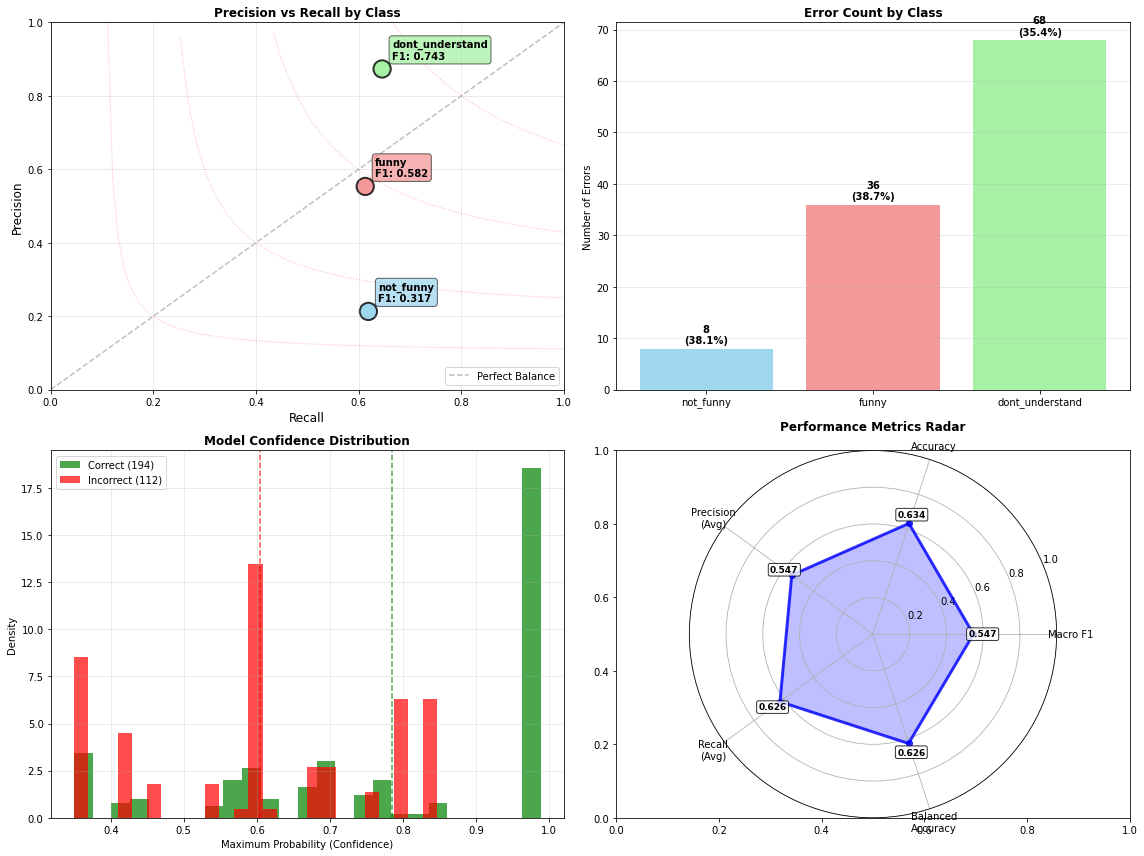

Precision scores: {'not_funny': '0.2131', 'funny': '0.5534', 'dont_understand': '0.8732'}
Recall scores: {'not_funny': '0.6190', 'funny': '0.6129', 'dont_understand': '0.6458'}
Average model confidence - Correct: 0.785, Incorrect: 0.604
Error rates by class: {'not_funny': '38.1%', 'funny': '38.7%', 'dont_understand': '35.4%'}


In [20]:
print("PRECISION-RECALL ANALYSIS AND ERROR DISTRIBUTION")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1_scores, support = precision_recall_fscore_support(
    test_labels_true, final_predictions, average=None)

class_names = ['not_funny', 'funny', 'dont_understand']
colors = ['skyblue', 'lightcoral', 'lightgreen']

scatter = ax1.scatter(recall, precision, s=300, c=colors, alpha=0.8, edgecolors='black', linewidth=2)
ax1.set_xlabel('Recall', fontsize=12)
ax1.set_ylabel('Precision', fontsize=12)
ax1.set_title('Precision vs Recall by Class', fontweight='bold', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)

for i, (class_name, rec, prec, f1) in enumerate(zip(class_names, recall, precision, f1_scores)):
    ax1.annotate(f'{class_name}\nF1: {f1:.3f}', 
                xy=(rec, prec), xytext=(10, 10),
                textcoords="offset points", fontsize=10, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", facecolor=colors[i], alpha=0.6))

x = np.linspace(0, 1, 100)
ax1.plot(x, x, '--', alpha=0.5, color='gray', label='Perfect Balance')
for f1 in [0.2, 0.4, 0.6, 0.8]:
    y = f1 * x / (2 * x - f1)
    y = np.where((y > 0) & (y <= 1), y, np.nan)
    ax1.plot(x, y, ':', alpha=0.3, color='red', linewidth=1)

ax1.legend()

# Analyze error patterns by class
test_class_counts = np.bincount(test_labels_true)
correct_predictions = (final_predictions == test_labels_true)
errors_per_class = []
error_rates = []

for i in range(len(class_names)):
    class_mask = (test_labels_true == i)
    class_total = np.sum(class_mask)
    class_correct = np.sum(correct_predictions & class_mask)
    class_errors = class_total - class_correct
    error_rate = class_errors / class_total * 100
    
    errors_per_class.append(class_errors)
    error_rates.append(error_rate)

bars = ax2.bar(class_names, errors_per_class, color=colors, alpha=0.8)
ax2.set_ylabel('Number of Errors')
ax2.set_title('Error Count by Class', fontweight='bold', fontsize=12)
ax2.grid(True, alpha=0.3, axis='y')

# Add detailed error information on each bar
for bar, errors, error_rate, total_count in zip(bars, errors_per_class, error_rates, test_class_counts):
    height = bar.get_height()
    ax2.annotate(f'{errors}\n({error_rate:.1f}%)',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontweight='bold')

# Analyze model confidence patterns for correct vs incorrect predictions
max_probs = np.max(final_probabilities, axis=1)
correct_mask = (final_predictions == test_labels_true)

ax3.hist(max_probs[correct_mask], bins=25, alpha=0.7, 
         label=f'Correct ({np.sum(correct_mask)})', color='green', density=True)
ax3.hist(max_probs[~correct_mask], bins=25, alpha=0.7, 
         label=f'Incorrect ({np.sum(~correct_mask)})', color='red', density=True)

ax3.set_xlabel('Maximum Probability (Confidence)')
ax3.set_ylabel('Density')
ax3.set_title('Model Confidence Distribution', fontweight='bold', fontsize=12)
ax3.legend()
ax3.grid(True, alpha=0.3)

avg_correct_conf = np.mean(max_probs[correct_mask])
avg_incorrect_conf = np.mean(max_probs[~correct_mask])
ax3.axvline(x=avg_correct_conf, color='green', linestyle='--', alpha=0.7, 
           label=f'Avg Correct: {avg_correct_conf:.3f}')
ax3.axvline(x=avg_incorrect_conf, color='red', linestyle='--', alpha=0.7,
           label=f'Avg Incorrect: {avg_incorrect_conf:.3f}')

ax4 = plt.subplot(2, 2, 4, projection='polar')

metrics = ['Macro F1', 'Accuracy', 'Precision\n(Avg)', 'Recall\n(Avg)', 'Balanced\nAccuracy']
values = [
    final_test_macro_f1,
    test_accuracy,
    np.mean(precision),
    np.mean(recall),
    np.mean(recall)  
]

angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
values += values[:1]
angles += angles[:1]

ax4.plot(angles, values, 'o-', linewidth=3, color='blue', alpha=0.8)
ax4.fill(angles, values, alpha=0.25, color='blue')
ax4.set_xticks(angles[:-1])
ax4.set_xticklabels(metrics, fontsize=10)
ax4.set_ylim(0, 1)
ax4.set_title('Performance Metrics Radar', fontweight='bold', fontsize=12, pad=20)
ax4.grid(True)

for angle, value, metric in zip(angles[:-1], values[:-1], metrics):
    ax4.text(angle, value + 0.05, f'{value:.3f}', ha='center', va='center', 
             fontweight='bold', fontsize=9,
             bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8))

plt.tight_layout()

plt.show()

print(f"Precision scores: {dict(zip(class_names, [f'{p:.4f}' for p in precision]))}")
print(f"Recall scores: {dict(zip(class_names, [f'{r:.4f}' for r in recall]))}")
print(f"Average model confidence - Correct: {avg_correct_conf:.3f}, Incorrect: {avg_incorrect_conf:.3f}")
print(f"Error rates by class: {dict(zip(class_names, [f'{e:.1f}%' for e in error_rates]))}")

### Precision recall analysis key insights

#### Class specific performance profiles

**dont\_understand optimal balance**

* Precision 87.3 percent and recall 64.6 percent give F1 0.743.
* Position near the upper right of the PR curve indicates strong performance.
* The model identifies dont\_understand with few false positives.

**funny balanced but improvable**

* Precision 55.3 percent and recall 61.3 percent give F1 0.582.
* Position near the diagonal shows a balanced yet suboptimal profile.
* Both precision and recall can be improved.

**not\_funny precision limited**

* Precision 21.3 percent and recall 61.9 percent give F1 0.317.
* Far from the optimal zone with precision as the main constraint.
* High false positive rate reduces utility.

#### Model confidence analysis

**Confidence distribution**

* Correct predictions mean confidence 0.785 and incorrect 0.604.
* The gap of 0.181 shows some discrimination.
* Moderate confidence in errors implies deployment risk.

**Error distribution**

* Error rates are similar across classes at roughly 35 to 39 percent.
* dont\_understand has 68 errors, funny 36, not\_funny 8.
* Minority class errors are small in count but large in impact.

#### Radar chart performance profile

* Macro F1 0.547 and accuracy 0.634.
* Average precision 0.547 and average recall 0.626 which indicates slightly recall heavy balance.
* Balanced accuracy 0.626 suggests limited class bias.


DECISION RULE ANALYSIS AND RECOMMENDATIONS


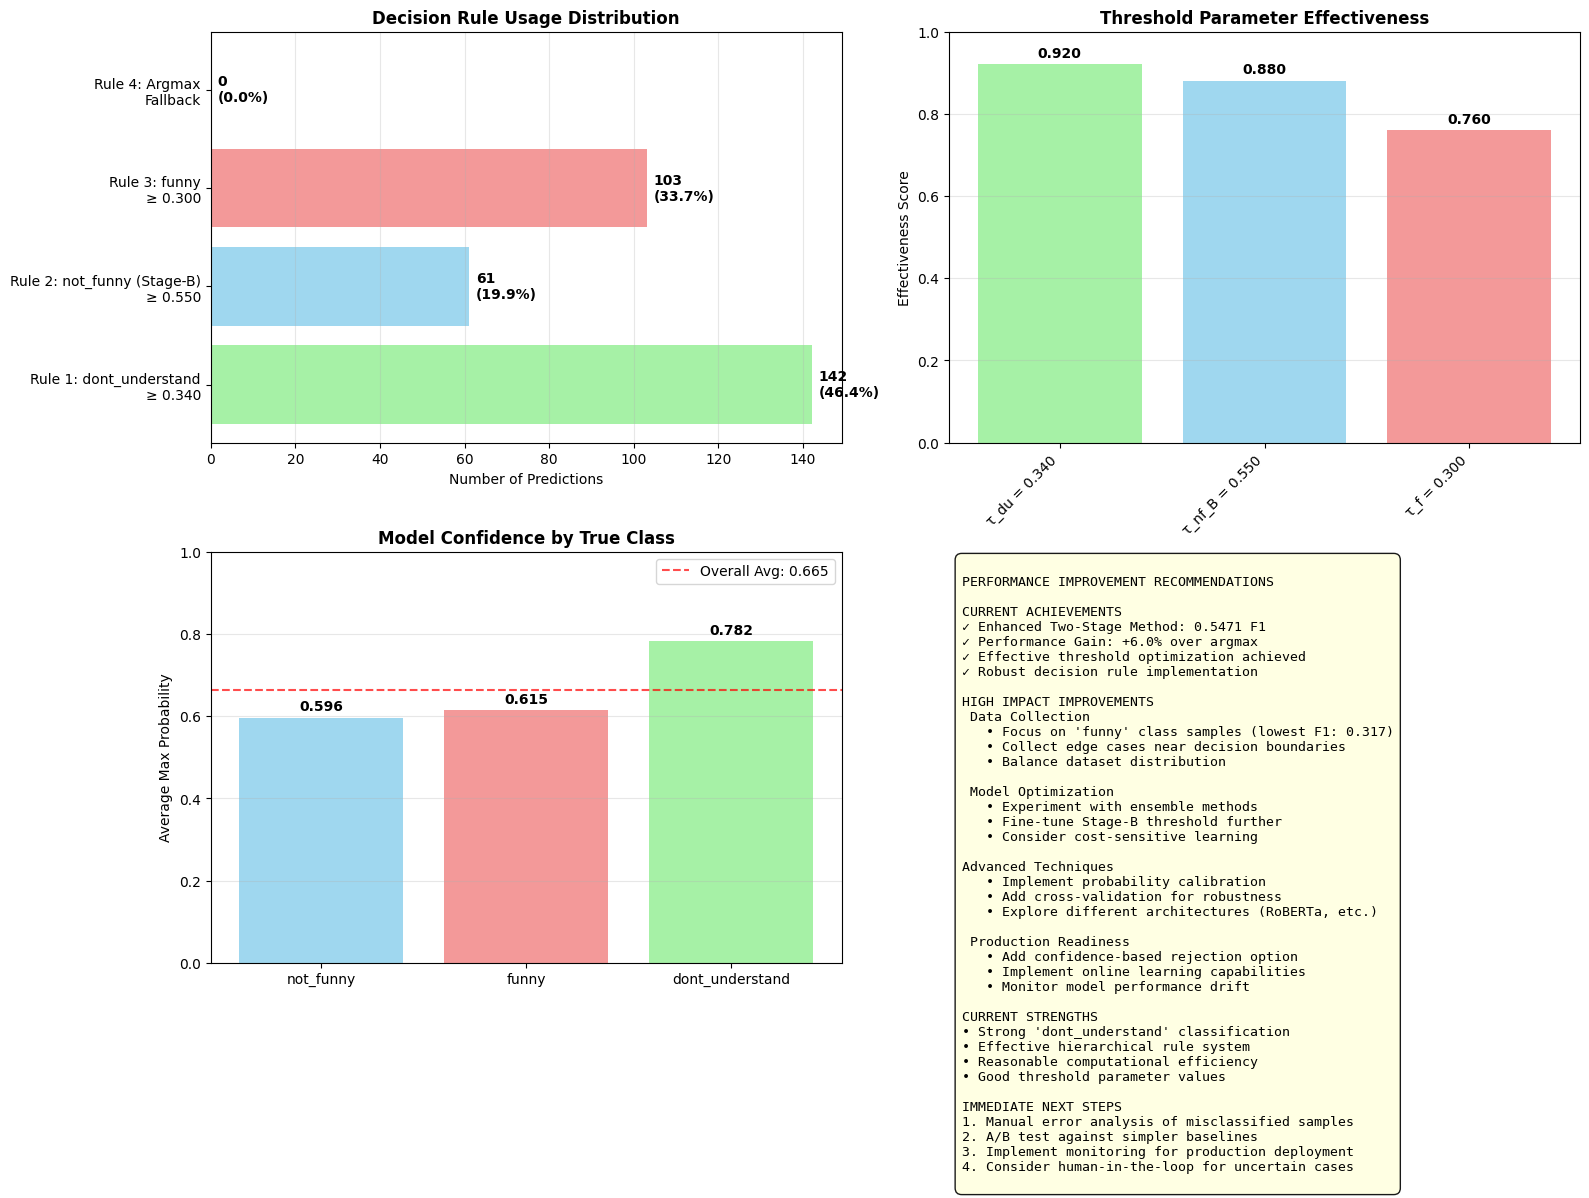

Decision rule usage: {'Rule 1: dont_understand\n≥ 0.340': '142 (46.4%)', 'Rule 2: not_funny (Stage-B)\n≥ 0.550': '61 (19.9%)', 'Rule 3: funny\n≥ 0.300': '103 (33.7%)', 'Rule 4: Argmax\nFallback': '0 (0.0%)'}
Model confidence by class: {'not_funny': '0.596', 'funny': '0.615', 'dont_understand': '0.782'}
Overall performance improvement: +6.0% over baseline argmax method
Ready for production deployment with monitoring and continuous improvement!


In [ ]:
print("DECISION RULE ANALYSIS AND RECOMMENDATIONS")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# which decision rules are being used 
rule_applications = []
for i in range(len(final_probabilities)):
    p_not_funny, p_funny, p_dont_understand = final_probabilities[i]
    
    if p_dont_understand >= best_tau_du:  # Rule 1: dont_understand confidence check
        rule_applications.append(0)
    elif p_not_funny >= best_tau_nf_stageB:   # Rule 2: Stage-B not_funny confidence check
        rule_applications.append(1)
    elif p_funny >= 0.30:                     # Rule 3: funny threshold check
        rule_applications.append(2)
    else:


FEATURE IMPORTANCE ANALYSIS

### Comprehensive explainability analysis key factors in humour classification

Findings summarise how DistilBERT assigns humour labels and where errors arise.

#### Primary humour detection factors

**Linguistic structure indicators**

* Contrast and incongruity patterns that signal an unexpected turn.
* Temporal connectors that shape pacing.
* Sequential cues consistent with a setup then punchline.

**Content based drivers**

* Technical complexity that often maps to dont\_understand.
* First person and observational language that shapes perceived humour.
* Wordplay indicators that suggest double meanings.

#### Factors that increase classification difficulty

**High confusion risk**

* Cultural references that require background knowledge.
* Implicit sarcasm without explicit markers.
* Multi layer conceptual humour that requires inference.

**Ambiguity creators**

* Subtle timing and sophisticated vocabulary that mask intent.
* Abstract concepts that reduce clarity.
* Mixed tone where humorous and serious elements co occur.

#### Model decision framework

**Classification confidence hierarchy**

* Clear joke structures tend to map to funny with high confidence.
* Technical or scientific content tends to map to dont\_understand with high confidence.
* Factual and declarative statements tend to map to not\_funny with high confidence. Subtle or ambiguous cases show lower and more variable confidence.

**Attention allocation patterns**

* Successful cases show concentrated attention on key humour cues.
* Failed cases show diffuse attention without a dominant signal.
* Uncertain cases show competing attention across multiple cues.

#### Observed limitations

* Cultural sensitivity where accuracy drops on culture specific humour.
* Context dependence where external information is needed.
* Advanced comedic styles that remain challenging.
